In [1]:
# Standard Library Imports
import os
import sys
from typing import List, Any, Callable, Union, Tuple, Optional
from importlib import reload

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cf
from pprint import pprint
from functools import partial
from glob import glob
import cftime
import json
import string

# Custom Module Imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_ds
import open_zecmip
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import zec_calculation_functions
import drift_functions
import sn_plotting
import stats

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# # Logging
# logger = utils.get_notebook_logger()

Matplotlib created a temporary config/cache directory at /jobfs/112568438.gadi-pbs/matplotlib-h1zj5u4h because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import listXarray as lxr
reload(lxr)
from listXarray import listXarray

In [3]:
# client.close()

In [4]:
from dask.distributed import Client
client = Client()
client

- State start
-   Scheduler at:     tcp://127.0.0.1:37273
-   dashboard at:        /proxy/34403/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:37415'
-         Start Nanny at: 'tcp://127.0.0.1:45083'
-         Start Nanny at: 'tcp://127.0.0.1:38845'
-         Start Nanny at: 'tcp://127.0.0.1:34127'
-         Start Nanny at: 'tcp://127.0.0.1:46725'
-         Start Nanny at: 'tcp://127.0.0.1:38671'
-         Start Nanny at: 'tcp://127.0.0.1:33227'
- Register worker <WorkerState 'tcp://127.0.0.1:41755', name: 5, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:41755
- Starting established connection to tcp://127.0.0.1:47472
- Register worker <WorkerState 'tcp://127.0.0.1:37631', name: 1, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:37631
- Starting established connection to tcp://127.0.0.1:47462
- Register worker <WorkerState 'tcp://127.0.0.1:35907', name: 3, status

<Client: 'tcp://127.0.0.1:37273' processes=7 threads=28, memory=251.18 GiB>

# Opening Data

In [5]:
chunks = {'lat':-1, 'lon':-1, 'time':-1, 'ensemble':-1}

In [6]:
a1_raw_xrlist = open_zecmip.extract_experiment_into_xrlist('1000pgc', 'tas', chunks=chunks, logginglevel='ERROR'
                                                          ).to_dataarray('tas').sort_by_refkey()

0.3.0


In [7]:
pct_raw_xrlist = open_zecmip.extract_experiment_into_xrlist('1pct', 'tas', chunks=chunks).to_dataarray('tas').sort_by_refkey()

In [8]:
esmpi_raw_xrlist = (open_zecmip.extract_experiment_into_xrlist('picontrol', 'tas', chunks=chunks, logginglevel='INFO')
                    .to_dataarray('tas')
                    .isel(ensemble=0)
                    .squeeze('ensemble')
                    .sort_by_refkey()
                    .rename({'latitude':'lat', 'longitude': 'lon'}))

- ACCESS-ESM1-5
-      r1i1p1f1 - /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/v20210316/*.nc
- CanESM5
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p1f1/Amon/tas/gn/v20190429/*.nc
-      r1i1p2f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p2f1/Amon/tas/gn/v20190429/*.nc
- MIROC-ES2L
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/tas/gn/v20190823/*.nc
- UKESM1-0-LL
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/v20200828/*.nc
- MPI-ESM1-2-LR
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r1i1p1f1/Amon/tas/gn/v20190710/*.nc
-      r2i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r2i1p1f1/Amon/tas/gn/v20190815/*.nc
- GISS-E2-1-G-CC
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G-CC/piControl/r1i1p1f1/Amon/tas/gn/v2

In [9]:
# Match all the ensemble dimensions
pct_raw_xrlist = pct_raw_xrlist.cross_match_dim(a1_raw_xrlist, 'ensemble')
a1_raw_xrlist = a1_raw_xrlist.cross_match_dim(pct_raw_xrlist, 'ensemble')

In [10]:
# Only selecting one ensemble member for each model
a1_raw_xrlist = a1_raw_xrlist.isel(ensemble=0).chunk('auto')
pct_raw_xrlist = pct_raw_xrlist.isel(ensemble=0).chunk('auto')
esmpi_raw_xrlist = esmpi_raw_xrlist.isel(ensemble=0).chunk('auto')

In [11]:
# After the year 1000 all values appear to be 0
#esmpi_raw_xrlist['CanESM5'] = esmpi_raw_xrlist['CanESM5'].isel(time=slice(None,1000))

In [12]:
esmpi_raw_xrlist['CanESM5']

<xarray.DataArray 'tas' (model: 1, time: 16800, lat: 64, lon: 128)>
dask.array<getitem, shape=(1, 16800, 64, 128), dtype=float32, chunksize=(1, 2400, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 5201-01-16 12:00:00 ... 6600-12-16 12:00:00
  * lat       (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * model     (model) <U7 'CanESM5'
    ensemble  <U8 'r1i1p1f1'
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    units:          K
    original_name:  ST
    history:        degctok 2019-04-30T17:18:16Z altered by CMOR: Treated sca...
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

# Global Mean Calculation

In [13]:
# Convert to celcius
a1_raw_xrlist = a1_raw_xrlist - 273.15
pct_raw_xrlist = pct_raw_xrlist - 273.15
esmpi_raw_xrlist = esmpi_raw_xrlist - 273.15

In [14]:
esmpi_regrid_xrlist = esmpi_raw_xrlist.chunk('auto').regrid('MPI-ESM1-2-LR', 'bilinear').set_refkeys('model')
pct_regrid_xrlist = pct_raw_xrlist.chunk('auto').regrid('MPI-ESM1-2-LR', 'bilinear').set_refkeys('model')
a1_regrid_xrlist = a1_raw_xrlist.chunk('auto').regrid('MPI-ESM1-2-LR', 'bilinear').set_refkeys('model')

In [15]:
# Making the data yearly
esmpi_xrlist = esmpi_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model').chunk('auto')
pct_xrlist = pct_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model').chunk('auto')
a1_xrlist = a1_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model').chunk('auto')

In [16]:
a1_xrlist

key_dim = model


Number of da/ds: 9
---------------
MPI-ESM1-2-LR ({'model': 1, 'time': 185, 'lat': 96, 'lon': 192})
ACCESS-ESM1-5 ({'model': 1, 'time': 101, 'lat': 96, 'lon': 192})
CESM2         ({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
CanESM5       ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
GFDL-ESM4     ({'model': 1, 'time': 200, 'lat': 96, 'lon': 192})
GISS-E2-1-G-CC({'model': 1, 'time': 180, 'lat': 96, 'lon': 192})
MIROC-ES2L    ({'model': 1, 'time': 248, 'lat': 96, 'lon': 192})
NorESM2-LM    ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
UKESM1-0-LL   ({'model': 1, 'time': 330, 'lat': 96, 'lon': 192})

In [17]:
# Subsetting to only first 150 years so all models have equal footing

# Reduce time so that the smalles time densions matches. This is at 101 years
a1_xrlist = a1_xrlist.isel(time=slice(None, 100))
a1_xrlist

key_dim = model


Number of da/ds: 9
---------------
MPI-ESM1-2-LR ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
ACCESS-ESM1-5 ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
CESM2         ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
CanESM5       ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
GFDL-ESM4     ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
GISS-E2-1-G-CC({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
MIROC-ES2L    ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
NorESM2-LM    ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
UKESM1-0-LL   ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})

In [18]:
# The global weighted mean
pct_smean_xrlist = pct_xrlist.chunk('auto').apply(sn.calculate_global_value, 'tas')

In [19]:
a1_smean_xrlist = a1_xrlist.chunk('auto').apply(sn.calculate_global_value, 'tas')

In [20]:
esmpi_smean_xrlist = esmpi_xrlist.apply(sn.calculate_global_value, 'tas')

In [21]:
esmpi_smean_xrlist = esmpi_smean_xrlist.compute()

In [22]:
a1_smean_xrlist = a1_smean_xrlist.compute()

In [23]:
pct_smean_xrlist = pct_smean_xrlist.compute()

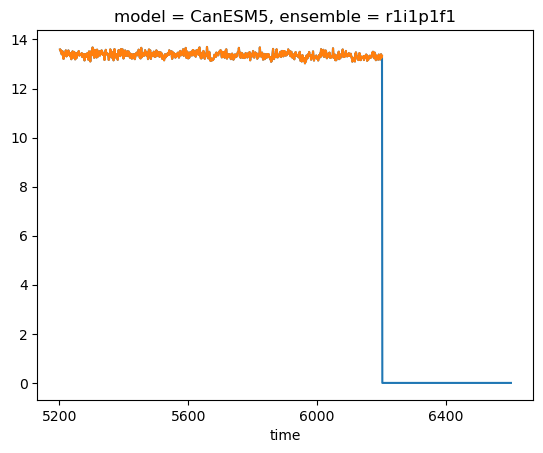

In [24]:
esmpi_smean_xrlist['CanESM5'].plot()
esmpi_smean_xrlist['CanESM5'].isel(time=slice(None, 1000)).plot()

In [25]:
esmpi_smean_xrlist['CanESM5'] = esmpi_smean_xrlist['CanESM5'].isel(time=slice(None, 1000))

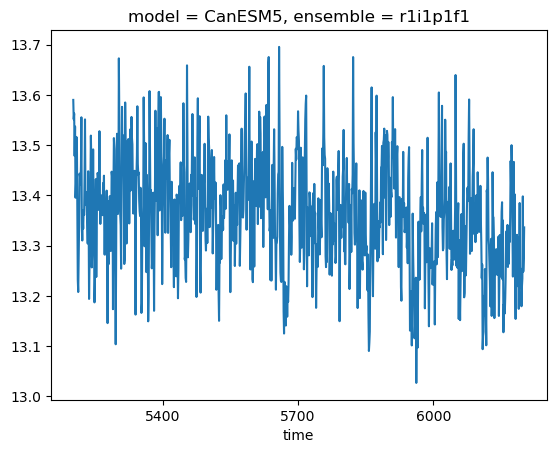

In [26]:
esmpi_smean_xrlist['CanESM5'].plot()

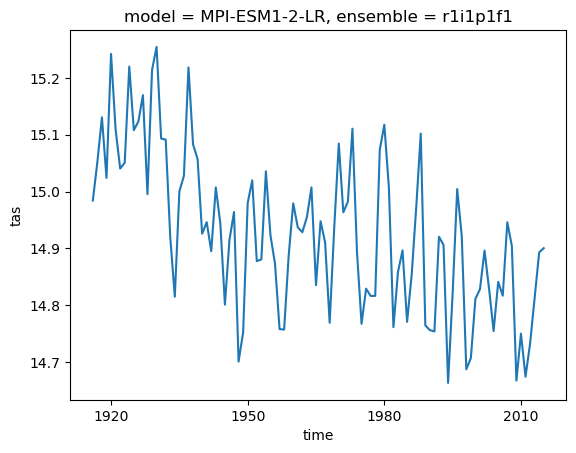

In [27]:
a1_smean_xrlist[0].plot()

In [28]:
# Calculate the values at the branching point
branch_point_mean_xrlist = listXarray([zec_calculation_functions.calculate_branch_average(
    pct_smean_xrlist[model], a1_smean_xrlist[model], logginglevel='INFO') for model in pct_smean_xrlist.refkeys]).set_refkeys('model')

- ['MPI-ESM1-2-LR'] - ['MPI-ESM1-2-LR']
- branch_start_time=cftime.DatetimeProlepticGregorian(1915, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=65
- 

- ['ACCESS-ESM1-5'] - ['ACCESS-ESM1-5']
- branch_start_time=cftime.DatetimeProlepticGregorian(168, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CESM2'] - ['CESM2']
- branch_start_time=cftime.DatetimeNoLeap(68, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CanESM5'] - ['CanESM5']
- branch_start_time=cftime.DatetimeNoLeap(1911, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=61
- 

- ['GFDL-ESM4'] - ['GFDL-ESM4']
- branch_start_time=cftime.DatetimeNoLeap(64, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=63
- 

- ['GISS-E2-1-G-CC'] - ['GISS-E2-1-G-CC']
- branch_start_time=cftime.DatetimeNoLeap(1920, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=70
- 

- ['MIROC-ES2L'] - ['MIROC-ES2L']
- branch_start_time=cftime.DatetimeGregorian(1913, 

In [29]:
# The amomaly time series from the branch point
a1_smean_anom_xrlist = (a1_smean_xrlist - branch_point_mean_xrlist).compute()

In [30]:
a1_smean_xrlist

key_dim = model


Number of da/ds: 9
---------------
MPI-ESM1-2-LR ({'model': 1, 'time': 100})
ACCESS-ESM1-5 ({'model': 1, 'time': 100})
CESM2         ({'model': 1, 'time': 100})
CanESM5       ({'model': 1, 'time': 100})
GFDL-ESM4     ({'model': 1, 'time': 100})
GISS-E2-1-G-CC({'model': 1, 'time': 100})
MIROC-ES2L    ({'model': 1, 'time': 100})
NorESM2-LM    ({'model': 1, 'time': 100})
UKESM1-0-LL   ({'model': 1, 'time': 100})

In [31]:
# All modles now have matching coordinates - can now be converted to xarray
# previosly a1 was a1_smean_anom_xrlist
a1_smean_anom_ds = a1_smean_anom_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model')
a1_smean_ds = a1_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model')
pct_smean_ds = pct_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model')
esmpi_smean_ds = esmpi_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model')

In [32]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_ds = a1_smean_anom_ds.isel(time=slice(15, 35)).mean(dim='time')
zec50_ds = a1_smean_anom_ds.isel(time=slice(40, 60)).mean(dim='time')
zec50_ds

<xarray.DataArray 'tas' (model: 9)>
array([-0.27015668,  0.01130198, -0.3096341 , -0.10102565, -0.20398543,
       -0.08966743, -0.1082242 , -0.33274778,  0.28783543])
Coordinates:
  * model     (model) <U14 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
    ensemble  <U8 'r1i1p1f1'

In [33]:
zec50_ds.to_pandas().sort_index().round(2)

model
ACCESS-ESM1-5     0.01
CESM2            -0.31
CanESM5          -0.10
GFDL-ESM4        -0.20
GISS-E2-1-G-CC   -0.09
MIROC-ES2L       -0.11
MPI-ESM1-2-LR    -0.27
NorESM2-LM       -0.33
UKESM1-0-LL       0.29
dtype: float64

In [34]:
a1_smean_anom_ds = a1_smean_anom_ds.dropna(dim='time')

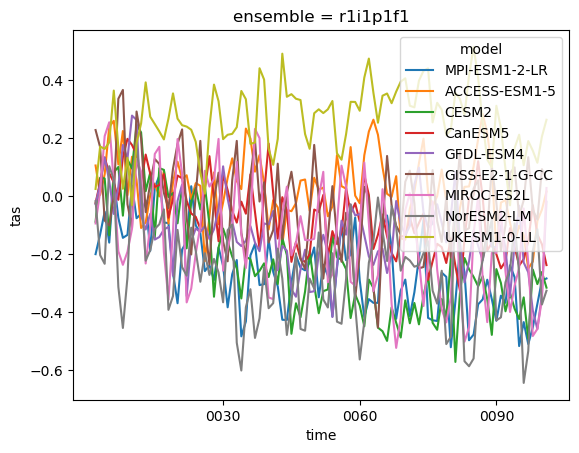

In [35]:
a1_smean_anom_ds.plot(hue='model');

# SN Calculation

In [36]:
# Detrend the data
a1_smean_anom_trendfit_ds = stats.trend_fit(a1_smean_anom_ds, method='polynomial', order=4)
a1_smean_anom_detrend_ds = a1_smean_anom_ds - a1_smean_anom_trendfit_ds

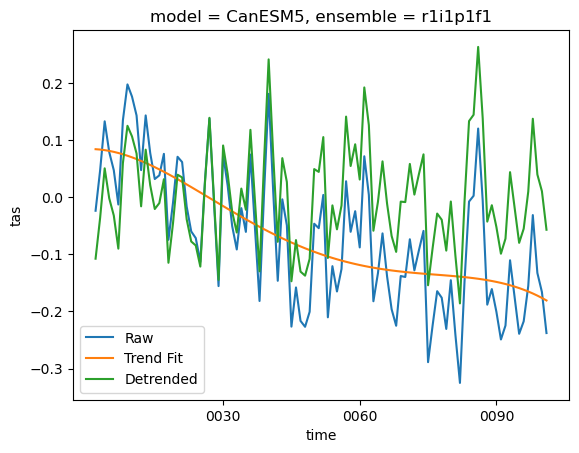

In [37]:
model = 'CanESM5'#'CESM2'
a1_smean_anom_ds.sel(model=model).plot(label='Raw')
a1_smean_anom_trendfit_ds.sel(model=model).plot(label='Trend Fit')
a1_smean_anom_detrend_ds.sel(model=model).plot(label='Detrended')
plt.legend()

In [38]:
%%time
# Calculate thje rolling and non rolling signal to noise

# Params to use for both
SN_PARAMS = dict(return_all=True, center=True, return_control=True, logginglevel='ERROR')

# Static
sn_multi_static_ds, sn_multi_static_control_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    a1_smean_anom_ds, esmpi_smean_ds, da_for_noise = a1_smean_anom_detrend_ds,
    rolling_noise=False, lower_bound=5, upper_bound=95,  **SN_PARAMS, **constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS)

# Rolling
sn_multi_rolling_ds, sn_multi_rolling_control_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    a1_smean_anom_ds, esmpi_smean_ds, da_for_noise = a1_smean_anom_detrend_ds,
    rolling_noise=True, lower_bound=5, upper_bound=95,  **SN_PARAMS, **constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS)

# Set refkeys and compute
sn_multi_static_ds = sn_multi_static_ds.compute()
sn_multi_rolling_ds = sn_multi_rolling_ds.compute()


Experiment
--------

Concatenating objects - PLEASE be patient!
 - Finished

Control
------


Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge

Experiment
--------
10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge
CPU times: user 6.12 s, sys: 343 ms, total: 6.46 s
Wall time: 6.04 s


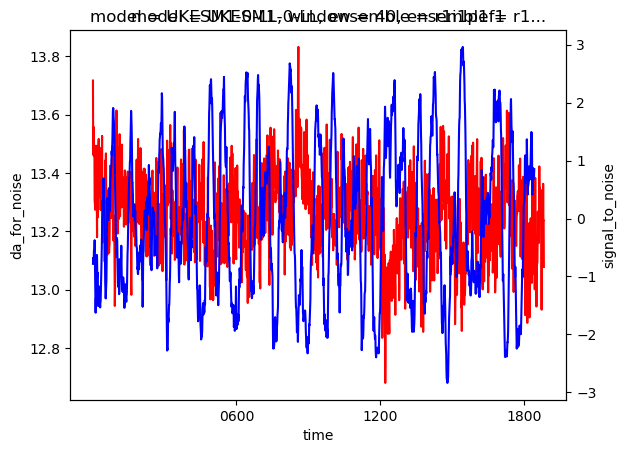

In [39]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
esmpi_smean_ds.sel(model='UKESM1-0-LL').plot(ax=ax, color='red')
sn_multi_rolling_control_ds.signal_to_noise.sel(model='UKESM1-0-LL', window=40).plot(ax=ax2, color='blue')

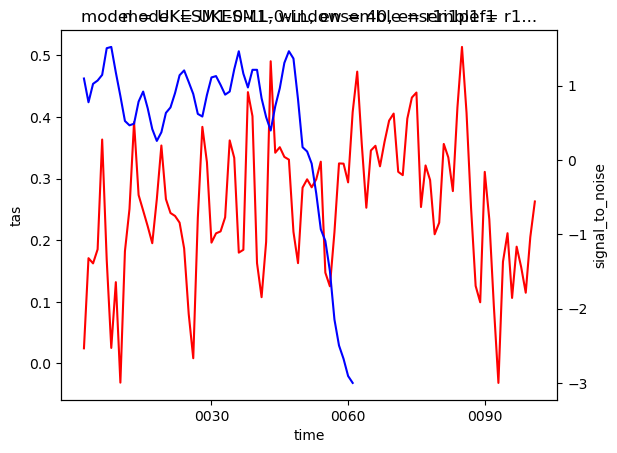

In [40]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
a1_smean_anom_ds.sel(model='UKESM1-0-LL').plot(ax=ax, color='red')
sn_multi_rolling_ds.signal_to_noise.sel(model='UKESM1-0-LL', window=40).plot(ax=ax2, color='blue')

In [41]:
# This is the length that all of the plots shoudl go to
# The end window is from the np.arange, and so goes to one before (so subtract one).
max_effective_length = len(sn_multi_rolling_ds.time.values) - (constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS['end_window']-1)
max_effective_length

60

In [42]:
# Calculate the year that each is stable
# I want both a dataset version (all ensembles) and a da version (ensemble mean but easier to use)

# Rolling
rolling_year_stable_ds = sn.get_stable_year_ds(sn_multi_rolling_ds, max_effective_length=max_effective_length)

# Static
static_year_stable_ds =sn.get_stable_year_ds(sn_multi_static_ds, max_effective_length=max_effective_length)

static_year_stable_ds

<xarray.Dataset>
Dimensions:   (model: 9, window: 31, variable: 1)
Coordinates:
  * model     (model) <U14 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * window    (window) int64 10 11 12 13 14 15 16 17 ... 33 34 35 36 37 38 39 40
    ensemble  <U8 'r1i1p1f1'
  * variable  (variable) object 'signal_to_noise'
Data variables:
    time      (variable, window, model) int64 0 5 10 0 10 6 ... 16 10 36 0 33 0

In [43]:
# # Number of models stable at each time step.
rolling_stability_levels_ds = sn.stability_levels(sn_multi_rolling_ds)
static_stability_levels_ds = sn.stability_levels(sn_multi_rolling_ds)

In [44]:
# Just the unstalgbe points - both xrlist and ds
above_or_below_kwargs = dict(main_var='signal_to_noise', greater_than_var='upper_bound', less_than_var='lower_bound')

unstable_rolling_ds = sn_multi_rolling_ds.utils.above_or_below(**above_or_below_kwargs)
unstable_static_ds = sn_multi_static_ds.utils.above_or_below(**above_or_below_kwargs)

In [45]:
# For each window get the number of years that are stable forn each point in time
decreasing_ds = xr.where(unstable_rolling_ds < 0, 1, 0)
increasing_ds = xr.where(unstable_rolling_ds > 0, 1, 0)

# Plots

In [46]:
def format_null_axis(ax):
    '''
    Axis that doesn't have any spines, or y tick labels or locaionts
    '''
    [ax.spines[sp].set_visible(False) for sp in ['top', 'left', 'right']]
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_title('')
    ax.set_ylabel('')

In [47]:
# Manual Calculation for Demonstations
WINDOW=25
# Sample period is the years that we want to look at
sample_period = (0,WINDOW) #(1200,1261), 61

# The length of the sample_period varible
window_length = WINDOW
imodel = 2

In [48]:
sample_data = a1_smean_anom_ds.isel(time=slice(*sample_period), model=imodel)

In [49]:
reload(sn_plotting)

<module 'sn_plotting' from '/home/563/ab2313/Documents/PhD/modules/sn_plotting.py'>

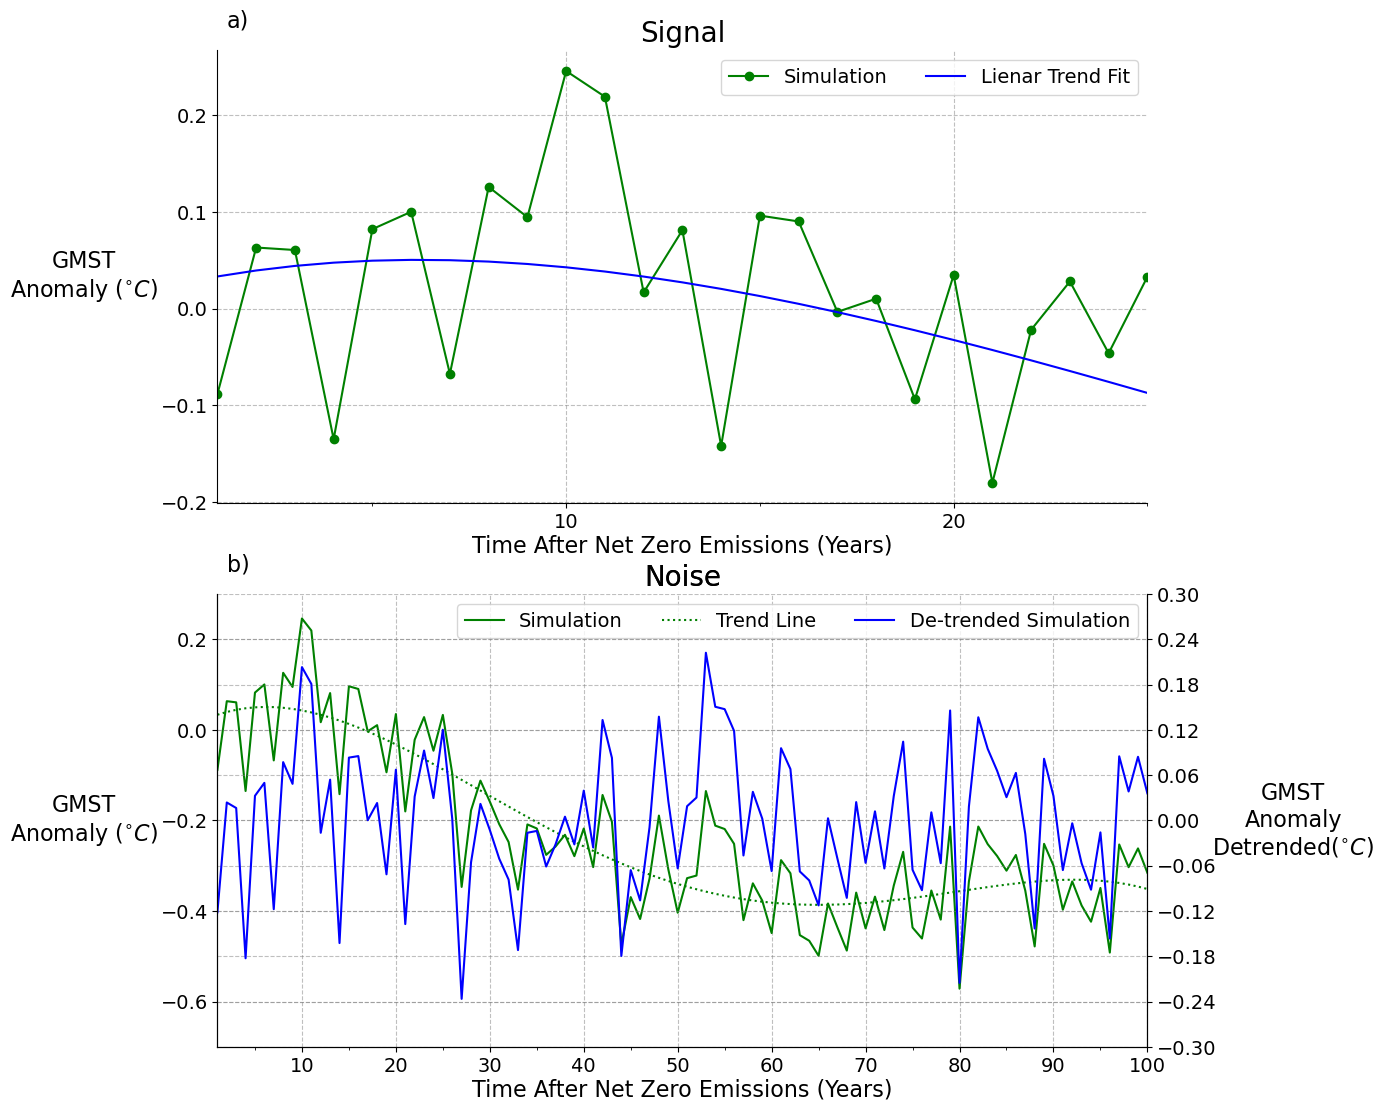

In [50]:
plt.style.use('default')
fig = plt.figure(figsize=(12,20))
axes = [fig.add_subplot(3,1,i) for i in range(1,3)]


# ---> axes[0]
axes[0].plot(sample_data.time.dt.year.values, sample_data.values, marker='o', label='Simulation', color='green')
axes[0].plot(sample_data.time.dt.year.values, a1_smean_anom_trendfit_ds.isel(time=slice(*sample_period), model=imodel),
             label='Lienar Trend Fit', color='blue')
axes[0].set_xlim(sample_data.time.dt.year.values[0], sample_data.time.dt.year.values[-1])
axes[0].legend(ncol=2, fontsize=constants.PlotConfig.legend_text_size)

plotting_functions.format_axis(axes[0], title='Signal', xlabel='Time After Net Zero Emissions (Years)', ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)',
                               labelpad=55, invisible_spines=['top', 'right'])
plotting_functions.add_figure_label(axes[0], 'a)')
sn_plotting.format_ticks_as_years(axes[0], sample_data.time.dt.year.values, logginglevel='ERROR')

# ---> axes[1]
ax1 = axes[1]; ax2 = axes[1].twinx()
time = a1_smean_anom_ds.time.dt.year.values
lns1 = ax1.plot(time, a1_smean_anom_ds.isel(model=imodel).values, color='green', label='Simulation')
lns2 = ax1.plot(time, a1_smean_anom_trendfit_ds.isel(model=imodel).values, label='Trend Line', color='green', linestyle=':')
lns3 = ax2.plot(time, a1_smean_anom_detrend_ds.isel(model=imodel).values, label='De-trended Simulation', color='blue')
sn_plotting.format_ticks_as_years(axes[1], time, logginglevel='ERROR')
axes[1].set_xlim(np.take(time, [0, -1]))


plotting_functions.match_ticks(ax1, ax2, 'left')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, ncol=3, loc='best', fontsize=constants.PlotConfig.legend_text_size)

plotting_functions.format_axis(ax1, title='Noise', xlabel='Time After Net Zero Emissions (Years)', ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)',
                               labelpad=55, invisible_spines=['top'])
plotting_functions.format_axis(ax2, title='Noise', ylabel='GMST\nAnomaly\nDetrended' + r'($^{\circ}C$)',
                               labelpad=55, invisible_spines=['top'])
plotting_functions.add_figure_label(ax1, 'b)')

In [51]:
experiment_params = constants.EXPERIMENTS_TO_RUN[0]
experiment_params

{'variable': 'tas', 'mask': None, 'hemisphere': 'global'}

In [52]:
units = constants.VARIABLE_INFO[experiment_params["variable"]]["units"]
longname = constants.VARIABLE_INFO[experiment_params["variable"]]['longname']
hemisphere_title = string.capwords(experiment_params['hemisphere'].replace('_', ' '))
mask_title = f'({experiment_params["mask"]} only)' if experiment_params["mask"] else ''

In [53]:
reload(sn_plotting)

<module 'sn_plotting' from '/home/563/ab2313/Documents/PhD/modules/sn_plotting.py'>

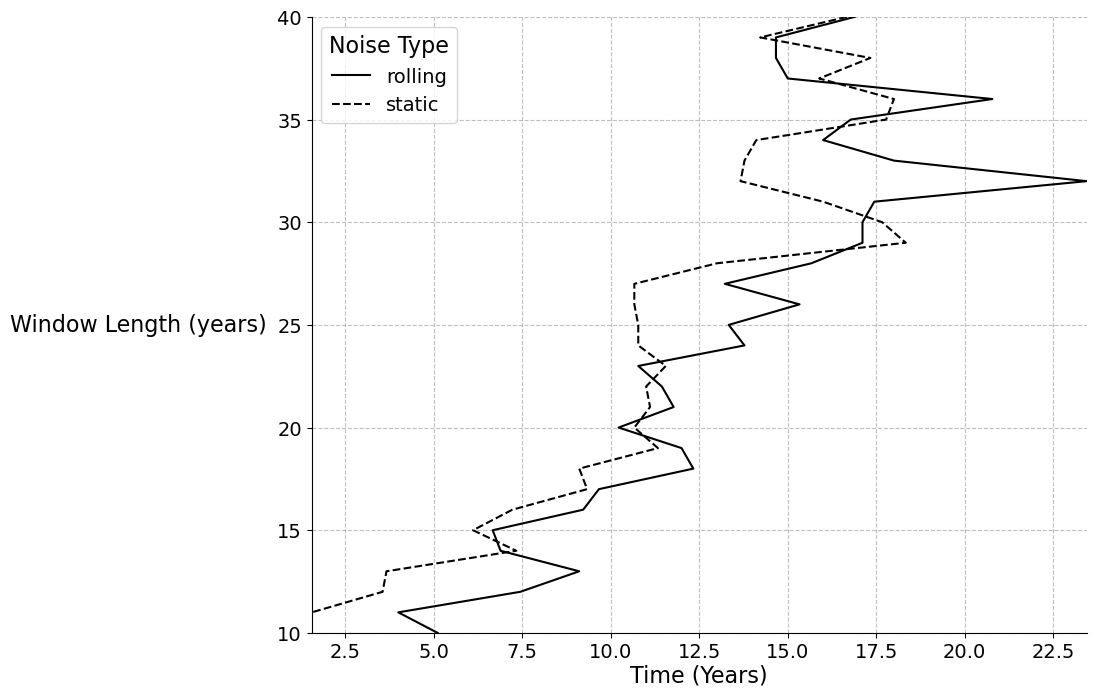

In [54]:
fig, ax = sn_plotting.plot_average_stable_year(static_year_stable_ds, rolling_year_stable_ds) # , xlabel='Time (Years)'

In [55]:
#### Note, this dictionary has also been put into constants as ZECMIP_MODEL_COLORS

# Create a list of models and their corresponding values
model_values = [(model, zec50_ds.sel(model=model).values.round(3)) for model in zec50_ds.model.values]

# Separate negative and positive values
negative_values = [(model, value) for model, value in model_values if value < 0]
positive_values = [(model, value) for model, value in model_values if value > 0]

# Sort the values by their absolute magnitude
negative_values.sort(key=lambda x: abs(x[1]))
positive_values.sort(key=lambda x: abs(x[1]))

# Create a colormap for negative values (BuPu_r) and positive values (OrRd)
# For the Blues we want to remove the three lower values there are too hard to see.  For the reds, just make sure it
# isn't the lower values. 
cut1 = 2
negative_colors = blue_colors = [
    '#add8e6',  # Light Blue
    '#87ceeb',  # Sky Blue
    '#6495ed',  # Cornflower Blue
    '#4169e1',  # Royal Blue
    '#1e90ff',  # Dodger Blue
    '#0000cd',  # Medium Blue
    '#00008b'   # Dark Blue
]
negative_line_styles = [
    '-',                # Solid
    '--',               # Dashed
    '-.',               # Dash-dot
    ':',                # Dotted
    '-',       # More frequent dashes, shorter space
    (0, (1, 1)),        # Densely dotted
    (0, (5, 1, 1, 1)),  # Dash, dot, dot, dot
]


#['#add8e6', '#87cefa', '#6495ed', '#4169e1', '#0000ff']#plt.cm.get_cmap('BuPu_r', len(negative_values)+cut1)(np.arange(len(negative_values)+cut1))[:-cut1]
positive_colors = plt.cm.get_cmap('OrRd', len(positive_values)+4)(np.arange(len(positive_values)+4))[::2][-2:]

# Create dictionaries for negative and positive values with color information
negative_zec50 = {model: {'value': value, 'color': color, 'linestyle':linestyle} for (model, value), color, linestyle in zip(negative_values, negative_colors, negative_line_styles)}
positive_zec50 = {model: {'value': value, 'color': color} for (model, value), color in zip(positive_values, positive_colors)}

# Combine the dictionaries into the final zec50_dict
zec50_dict = {**negative_zec50, **positive_zec50}
zec50_dict

{'GISS-E2-1-G-CC': {'value': -0.09, 'color': '#add8e6', 'linestyle': '-'},
 'CanESM5': {'value': -0.101, 'color': '#87ceeb', 'linestyle': '--'},
 'MIROC-ES2L': {'value': -0.108, 'color': '#6495ed', 'linestyle': '-.'},
 'GFDL-ESM4': {'value': -0.204, 'color': '#4169e1', 'linestyle': ':'},
 'MPI-ESM1-2-LR': {'value': -0.27, 'color': '#1e90ff', 'linestyle': '-'},
 'CESM2': {'value': -0.31, 'color': '#0000cd', 'linestyle': (0, (1, 1))},
 'NorESM2-LM': {'value': -0.333,
  'color': '#00008b',
  'linestyle': (0, (5, 1, 1, 1))},
 'ACCESS-ESM1-5': {'value': 0.011,
  'color': array([0.99137255, 0.6972549 , 0.48392157, 1.        ])},
 'UKESM1-0-LL': {'value': 0.288,
  'color': array([0.78666667, 0.11294118, 0.07294118, 1.        ])}}

In [56]:
rolling_year_stable_ds.sel(window=40).time.squeeze().to_pandas().to_dict()

{'MPI-ESM1-2-LR': 15,
 'ACCESS-ESM1-5': 0,
 'CESM2': 39,
 'CanESM5': 16,
 'GFDL-ESM4': 9,
 'GISS-E2-1-G-CC': 35,
 'MIROC-ES2L': 0,
 'NorESM2-LM': 36,
 'UKESM1-0-LL': 0}

Text(0.5, 1.0, '')

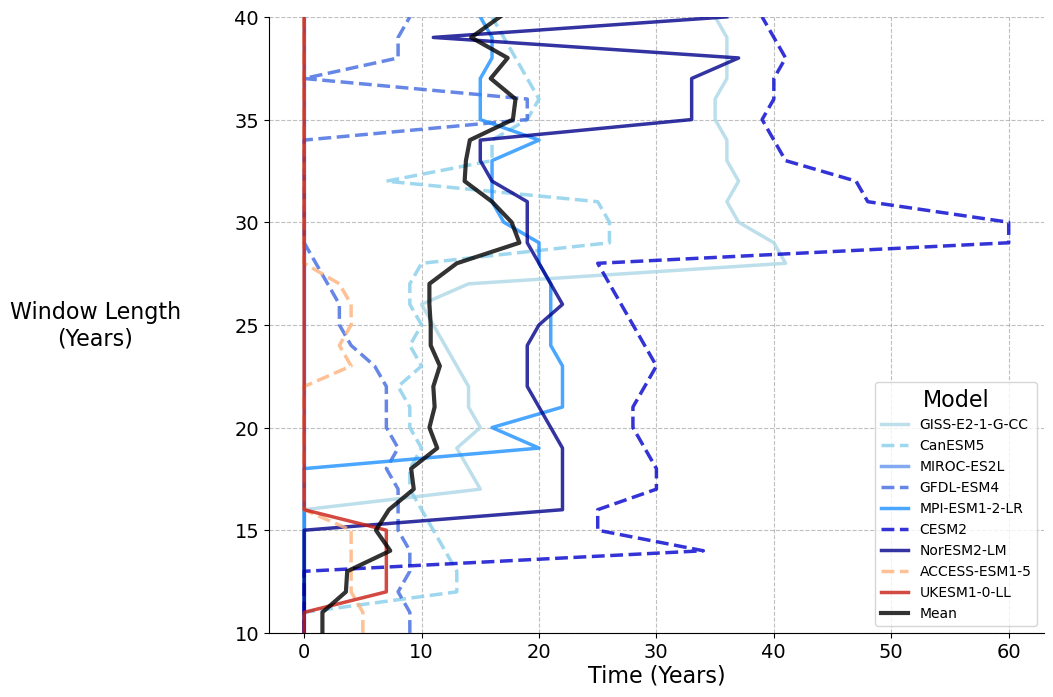

In [57]:
plt.style.use('default')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

for num, model in enumerate(zec50_dict):
    color = zec50_dict[model]['color']
    linestyle = '-' if not num%2 else '--'#zec50_dict[model]['linestyle'] if 'linestyle' in zec50_dict[model] else '-'
    rolling_year_stable_ds.sel(model=model).time.plot(ax=ax, y='window', linewidth=2.5, alpha=0.8, color=color, label=model, linestyle=linestyle)
        
rolling_year_stable_ds.time.mean(dim='model').plot(ax=ax, y='window', linewidth=3, alpha=0.8, color='k', label='Mean')     
leg = ax.legend()
leg.set_title('Model')
leg.get_title().set_fontsize(constants.PlotConfig.legend_title_size)
plotting_functions.format_axis(ax, xlabel='Time (Years)', ylabel='Window Length\n(Years)', invisible_spines=['top', 'right'])
ax.set_ylim([10, 40])
ax.set_title('')

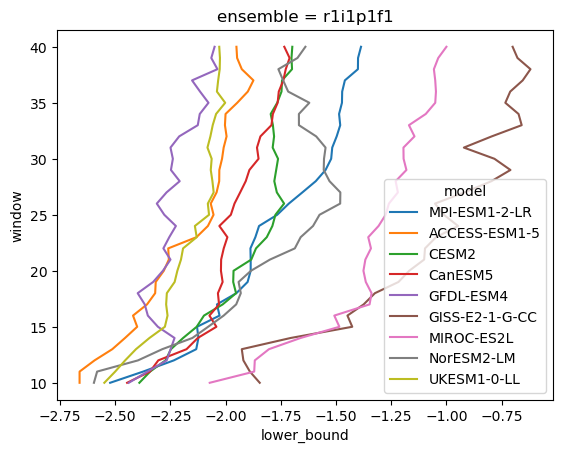

In [58]:
sn_multi_rolling_ds.lower_bound.plot(hue='model', y='window')

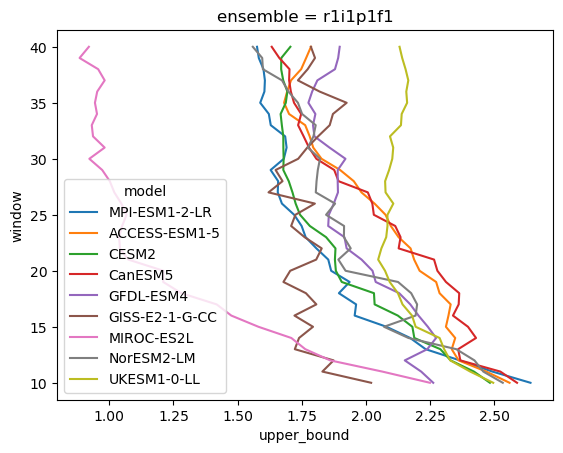

In [59]:
sn_multi_rolling_ds.upper_bound.plot(hue='model', y='window')

In [60]:
# stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=True, ax2_ylabel=f'GMST Anomaly({units})',
#                                   cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
#                                   cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise\nRatio', hspace=0.2,
#                                   return_all=True, rotation=90)
sn_levels = np.arange(-4.5, 4.5+.5, 0.5)
stability_colorplot_kwargs = dict(max_color_lim=max_effective_length, xlims=(0, 90), patch=True, ax2_ylabel='', ylabel='',
                                  cmap='RdBu_r', bbox_to_anchor=(1, 1.4), labelpad_left=65, labelpad_right=15, extend='both',
                                  cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio', hspace=0.2,
                                  return_all=True, rotation=90)

In [61]:
to_concat = []
for window in rolling_year_stable_ds.window.values:
    window_ds = rolling_year_stable_ds.sel(window=window)
    window_ds_pw = window_ds.copy(deep=True) + window
    window_ds_pw = xr.where(window_ds==0, 0, window_ds_pw)
    to_concat.append(window_ds_pw)
rolling_year_stable_ds_plus_window = xr.concat(to_concat, dim='window')

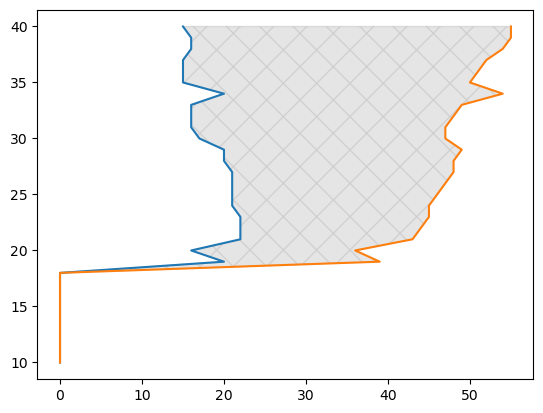

In [62]:
tds = rolling_year_stable_ds.isel(model=0).squeeze()
tds2 = rolling_year_stable_ds_plus_window.isel(model=0).squeeze()

plt.plot(tds.time.values, tds.window.values)

plt.plot(tds2.time.values, tds2.window.values)
plt.fill_betweenx(tds.window.values, tds.time.values, tds2.time.values,
                  color='grey', alpha=0.2, hatch='x')

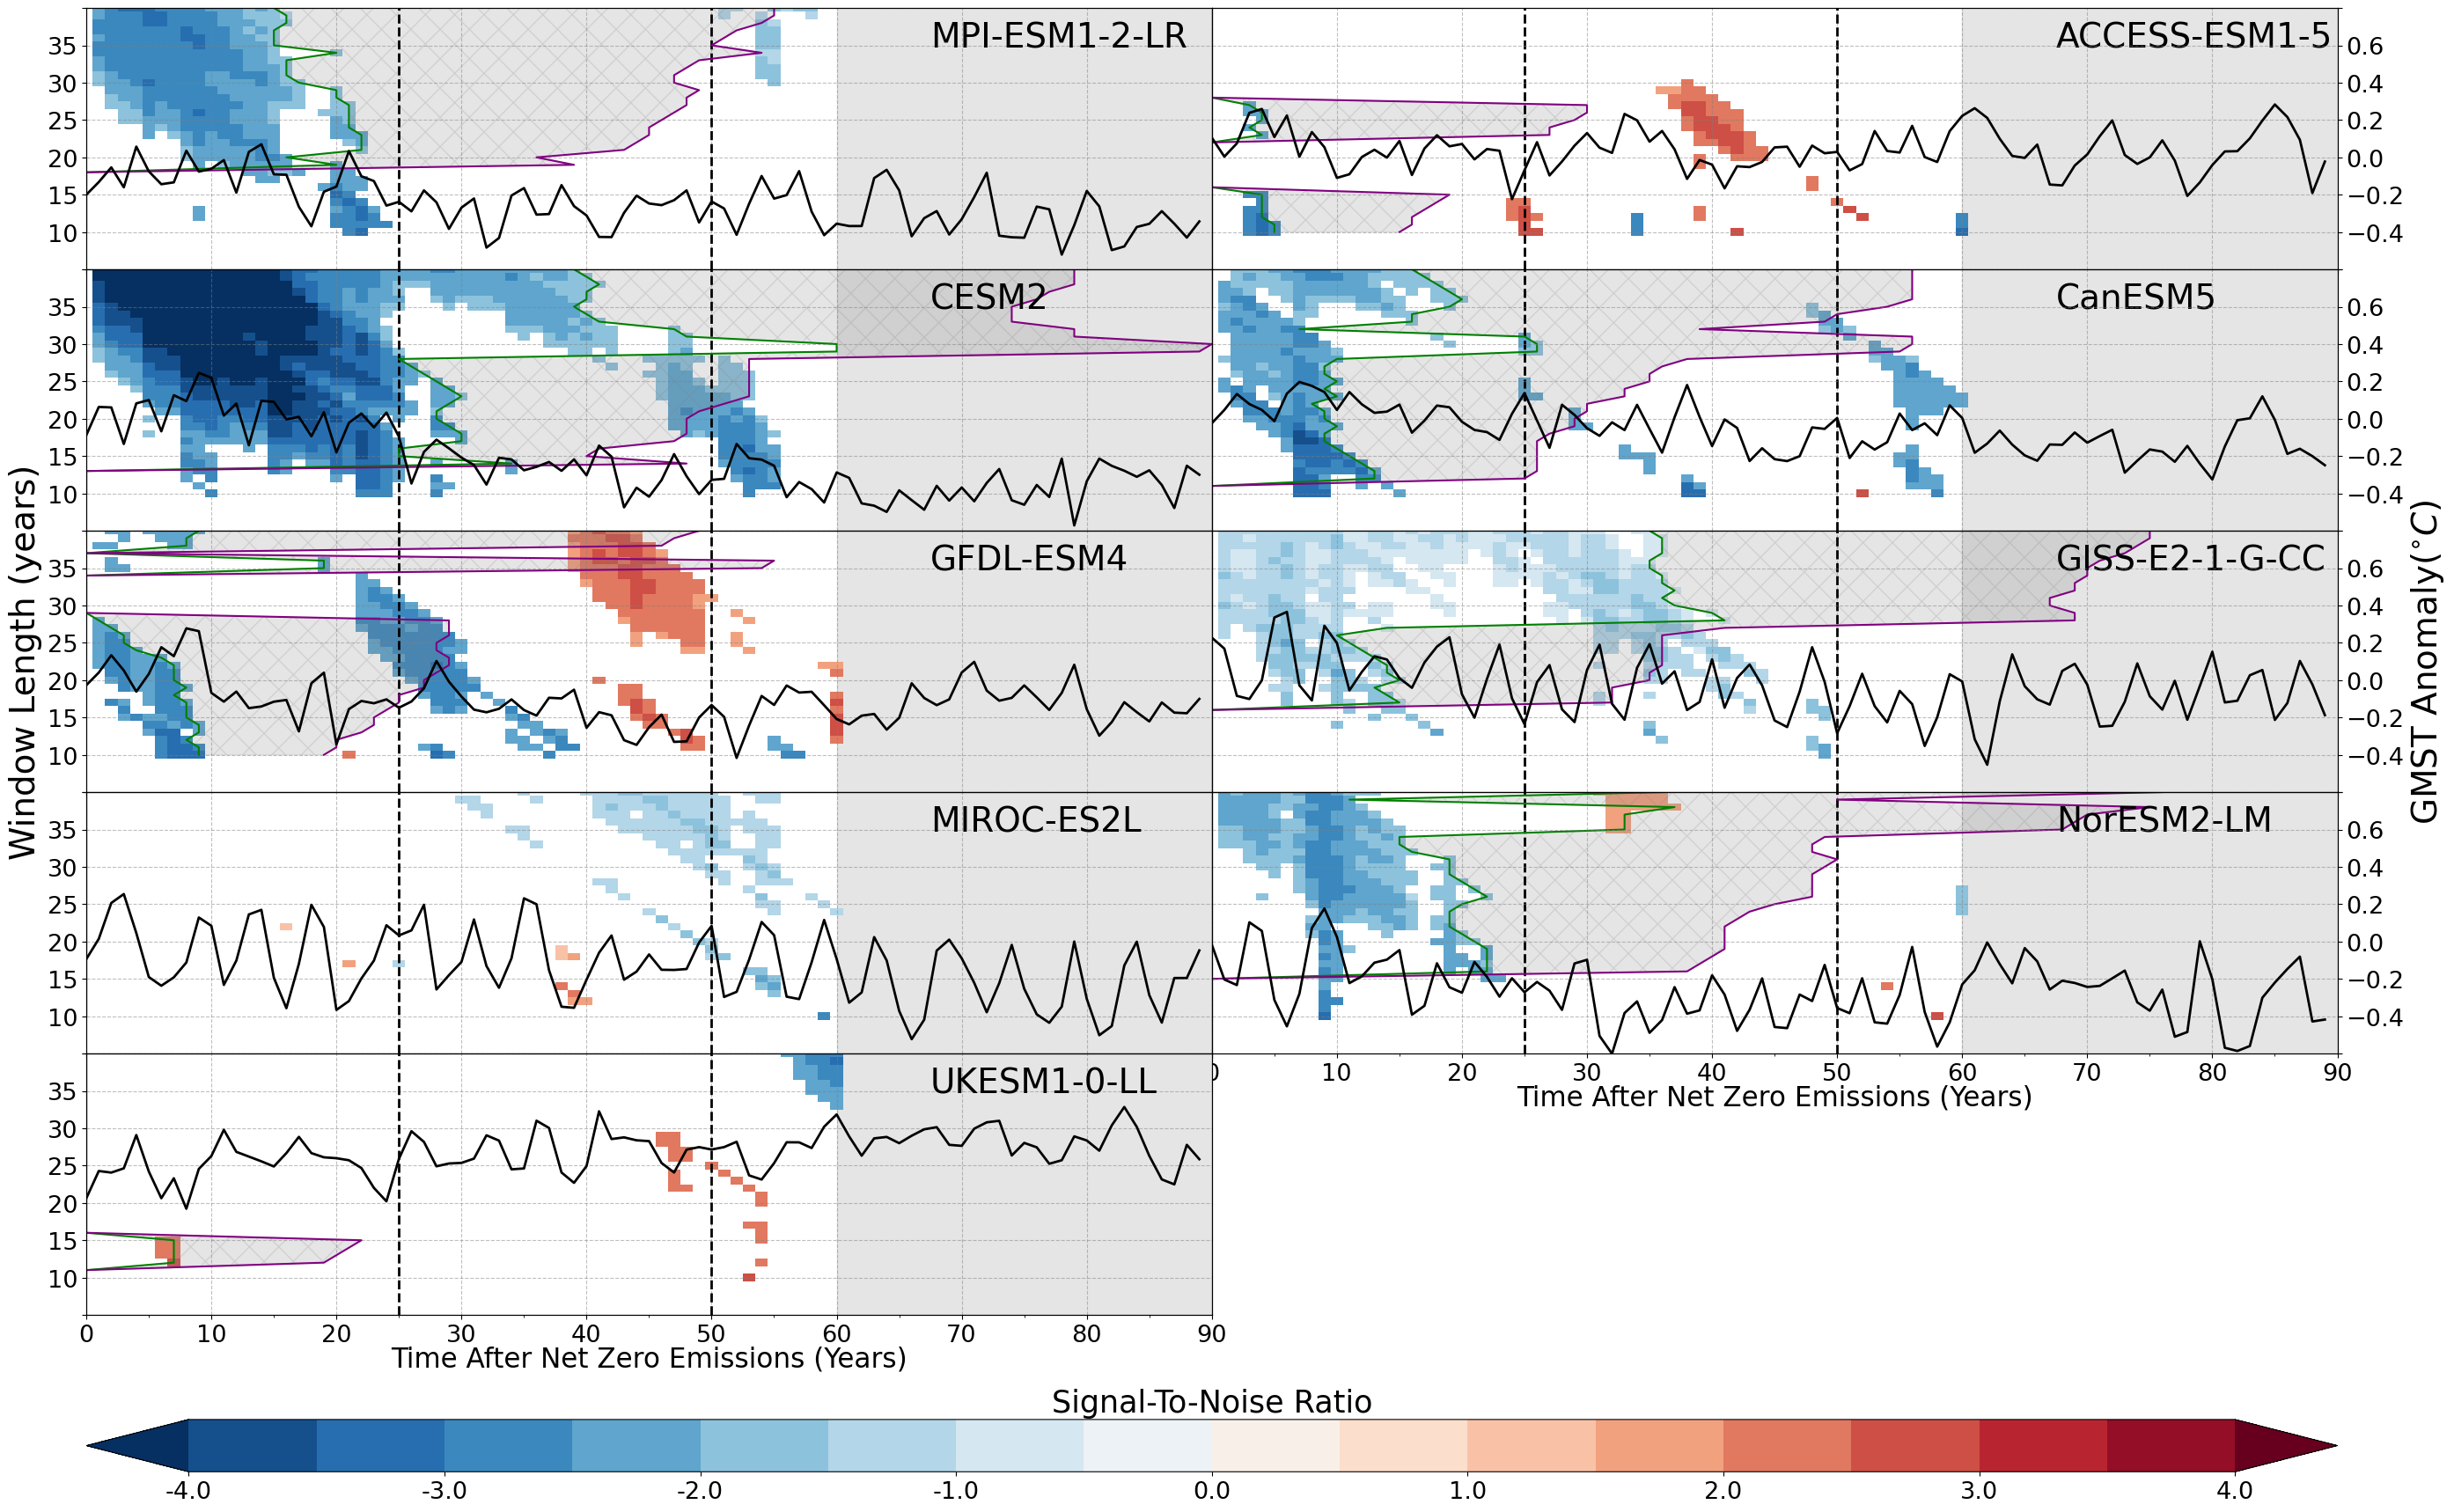

In [63]:
%matplotlib inline
models = unstable_rolling_ds.model.values

num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]
font_scale = 1.4
for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    #ax.set_ylim(8, 41)
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        unstable_rolling_ds.sel(model=model).squeeze().signal_to_noise,
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        #stable_point_ds = rolling_year_stable_ds_plus_window.sel(model=model),#rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs) 
    ax, ax2, cax = returned_axes
    ax.axvline(unstable_rolling_ds.time.dt.year.values[24], 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(unstable_rolling_ds.time.dt.year.values[49], 0, 1000, color='k', linewidth=2, linestyle='--')
    

    # Adding the stabilisation year and theb fill between
    tds = rolling_year_stable_ds.sel(model=model).squeeze()
    tds2 = rolling_year_stable_ds_plus_window.sel(model=model).squeeze()
    
    ax.plot(tds.time.values, tds.window.values, color='green')
    ax.plot(tds2.time.values, tds2.window.values, color='purple')
    
    ax.fill_betweenx(tds.window.values, tds.time.values, tds2.time.values,
                      color='grey', alpha=0.2, hatch='x')
    
    # rolling_year_stable_ds_plus_window.time.sel(model=model).plot(ax=ax, y='window')
    # rolling_year_stable_ds.time.sel(model=model).plot(ax=ax, y='window')
    if (num+1)%2: # Left plot
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        plotting_functions.clip_axis_ends(ax)
    else: # Right plot
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_ylabel(' ')
        plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    if num  == 4: ax.set_ylabel('Window Length (years)', size=constants.PlotConfig.title_size*font_scale)
    if num  == 5: ax2.set_ylabel(f'GMST Anomaly({units})', size=constants.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.75, 0.85), xycoords='axes fraction', ha='left', size=constants.PlotConfig.title_size*font_scale)
    
    if num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')

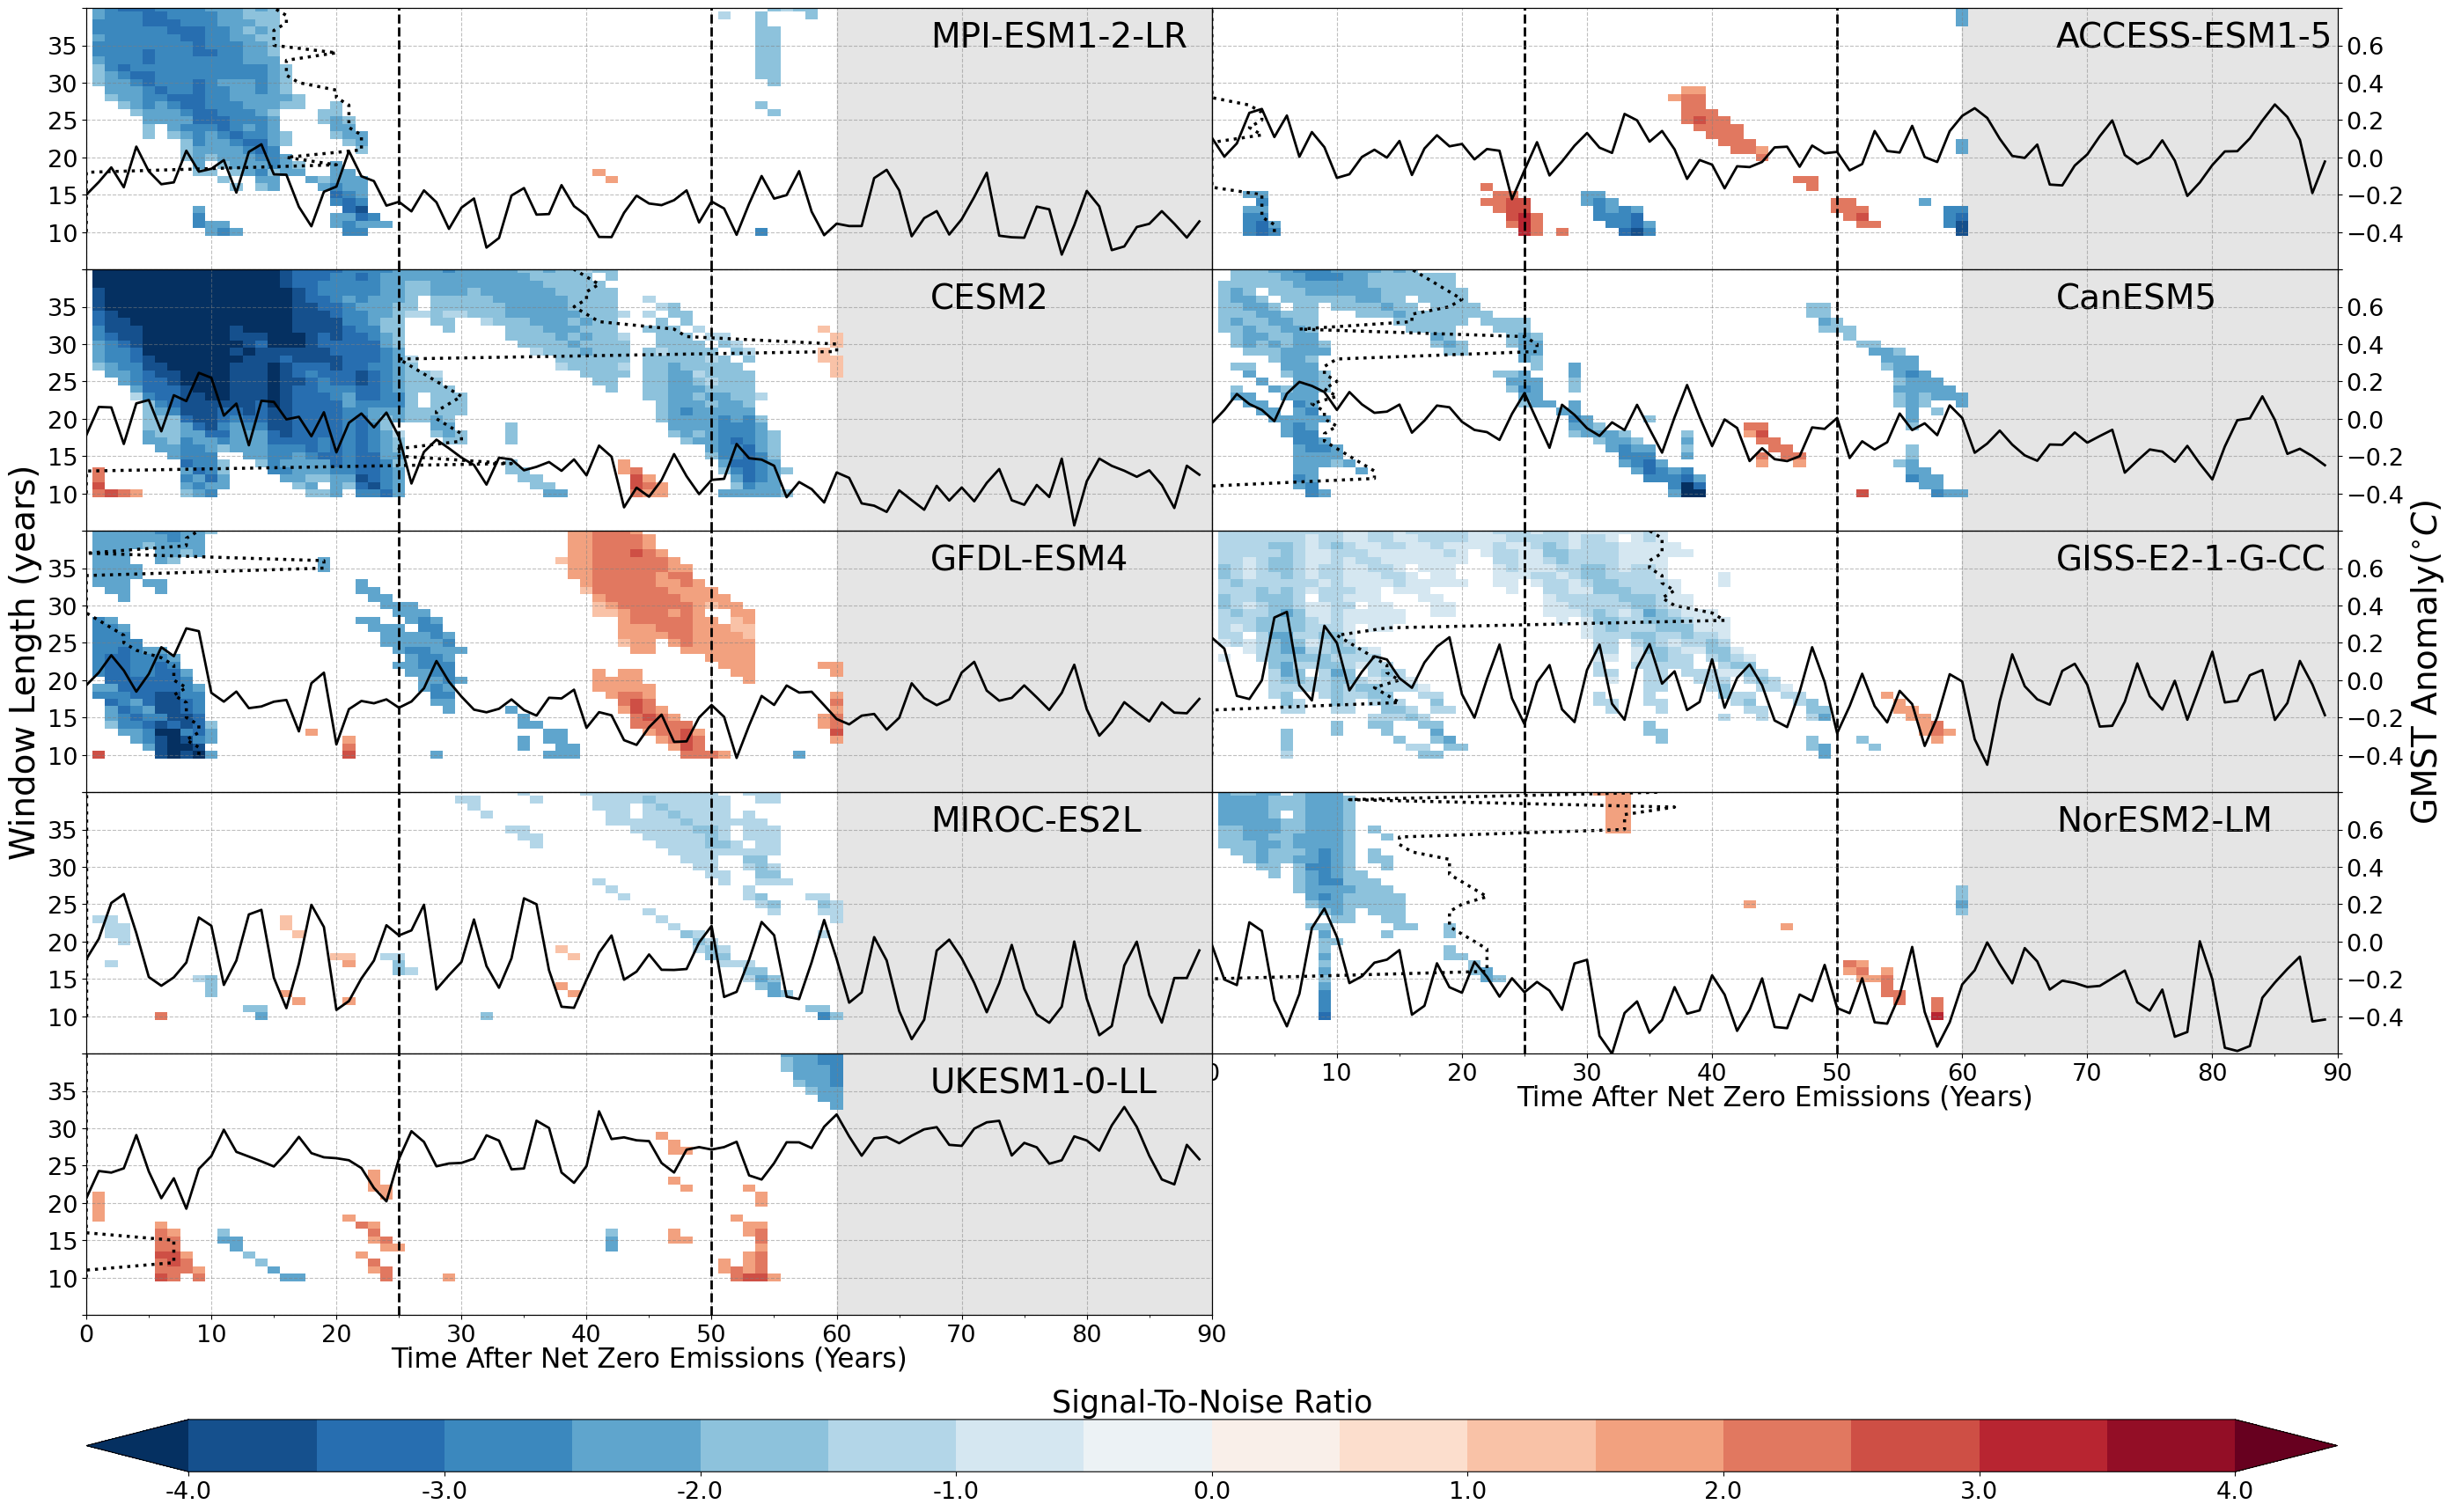

In [64]:
%matplotlib inline
models = unstable_rolling_ds.model.values

num_plots = len(models)
num_cols = 2
num_rows = int(np.ceil(num_plots/num_cols))

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*1.5,  sn_plotting.plot_kwargs['height']*num_plots/5))
gs = gridspec.GridSpec(num_rows+2, num_cols, height_ratios=num_rows*[1] + [0.4]+[0.2],hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(num_plots)]

for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if  num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num_rows+1, :])
    
    fig, returned_axes = sn_plotting.sn_multi_window_in_time(
        unstable_static_ds.sel(model=model).squeeze().signal_to_noise,
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        stable_point_ds = rolling_year_stable_ds.sel(model=model),#rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title='', yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs) 
    ax, ax2, cax = returned_axes
    ax.axvline(unstable_rolling_ds.time.dt.year.values[24], 0, 1000, color='k', linewidth=2, linestyle='--')
    ax.axvline(unstable_rolling_ds.time.dt.year.values[49], 0, 1000, color='k', linewidth=2, linestyle='--')
    #ax.set_ylim(9, 40)

    if (num+1)%2: # Left plot
        ax2.set_yticks([])
        ax2.set_yticklabels([])
        plotting_functions.clip_axis_ends(ax)
    else: # Right plot
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_ylabel(' ')
        plotting_functions.clip_axis_ends(ax2)

    ax.set_ylabel('')
    if num  == 4: ax.set_ylabel('Window Length (years)', size=constants.PlotConfig.title_size*font_scale)
    if num  == 5: ax2.set_ylabel(f'GMST Anomaly({units})', size=constants.PlotConfig.title_size*font_scale)
    ax.annotate(model, xy=(0.75, 0.85), xycoords='axes fraction', ha='left', size=constants.PlotConfig.title_size*font_scale)
    
    if num < 7:
        ax.set_xticklabels([])
        ax.set_xlabel('')

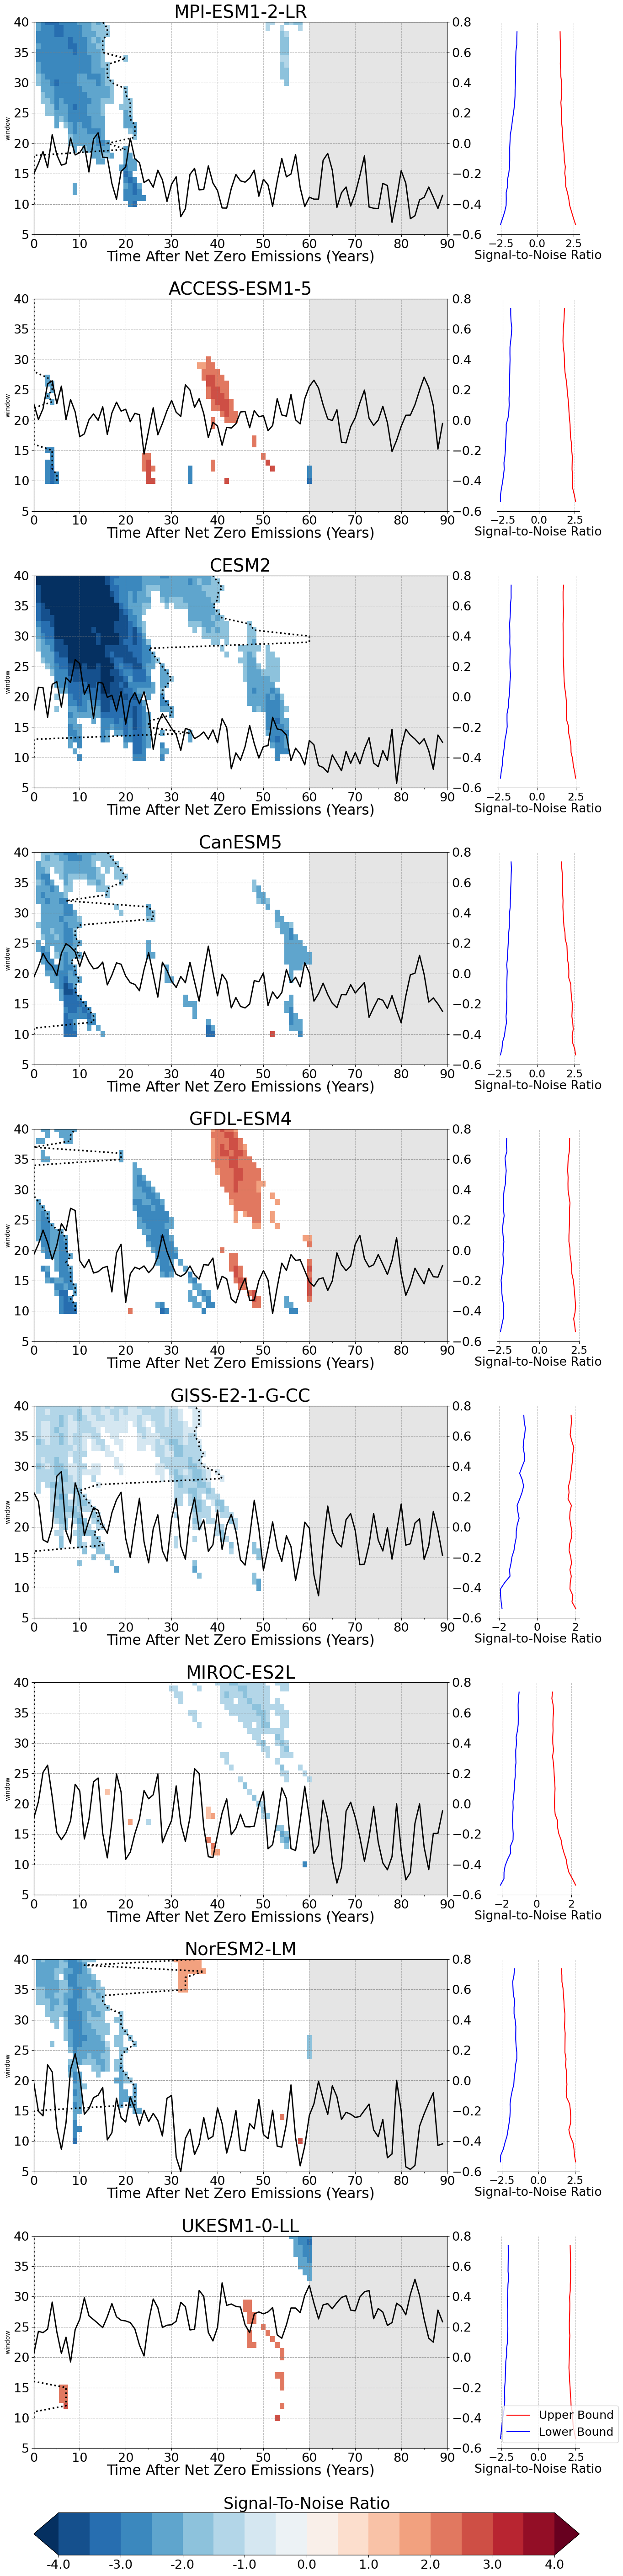

In [65]:
%matplotlib inline
models = unstable_rolling_ds.model.values

num_plots = len(models)

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width']*0.7,  sn_plotting.plot_kwargs['height']*num_plots/1.5))
gs = gridspec.GridSpec(num_plots+1, 2, height_ratios=num_plots*[1] + [0.2],
                       width_ratios=[1, 0.2], hspace=sn_plotting.plot_kwargs['hspace']*1.1)

axes_left = [fig.add_subplot(gs[i, 0]) for i in range(num_plots)]
axes_right = [fig.add_subplot(gs[i, 1]) for i in range(num_plots)]
for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num+1, :])
    
    sn_plotting.sn_multi_window_in_time(
        unstable_rolling_ds.sel(model=model).squeeze().signal_to_noise,
        temp_da=a1_smean_anom_ds.squeeze().sel(model=model),
        stable_point_ds = rolling_year_stable_ds.sel(model=model),
        fig=fig, gs=gs, ax=axes_left[num], cax=cax, add_colorbar=add_colorbar, yticks = np.arange(5, 45, 5),
        axes_title=model, yticks_right = np.arange(-0.6, 1, .2), **stability_colorplot_kwargs)  
    
    # Lower and upper bound plots
    sn_multi_rolling_ds.sel(model=model).upper_bound.plot(ax=axes_right[num], y='window', color='red', label='Upper Bound')
    sn_multi_rolling_ds.sel(model=model).lower_bound.plot(ax=axes_right[num], y='window', color='blue',label='Lower Bound')
    plotting_functions.format_axis(axes_right[num], xlabel='Signal-to-Noise Ratio', ylabel='',title='', font_scale=1.2)
    format_null_axis(axes_right[num])
    if num == len(models)-1:axes_right[num].legend(ncol=1, fontsize=18)
# axes = axes_left.extend(axes_right)
# for num, ax in enumerate(axes): plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=1.4)

In [66]:
stability_colorplot_kwargs_no_temp_line = dict(max_color_lim=max_effective_length, xlims=(0, max_effective_length),patch=False,
                                               ax2_ylabel=f'GMST Anomaly({units})', labelpad_left=70)

In [89]:
plot_kwargs = {'exp_type': 'zecmip','levels': np.arange(0, 11, 1), 'tick_offset': 'center',
               'extend': 'neither', 'cbar_label': 'Number of Models not in Equilibrium'}

In [90]:
my_blues = plotting_functions.create_discrete_cmap('BuPu', levels=plot_kwargs['levels'], add_white=True)

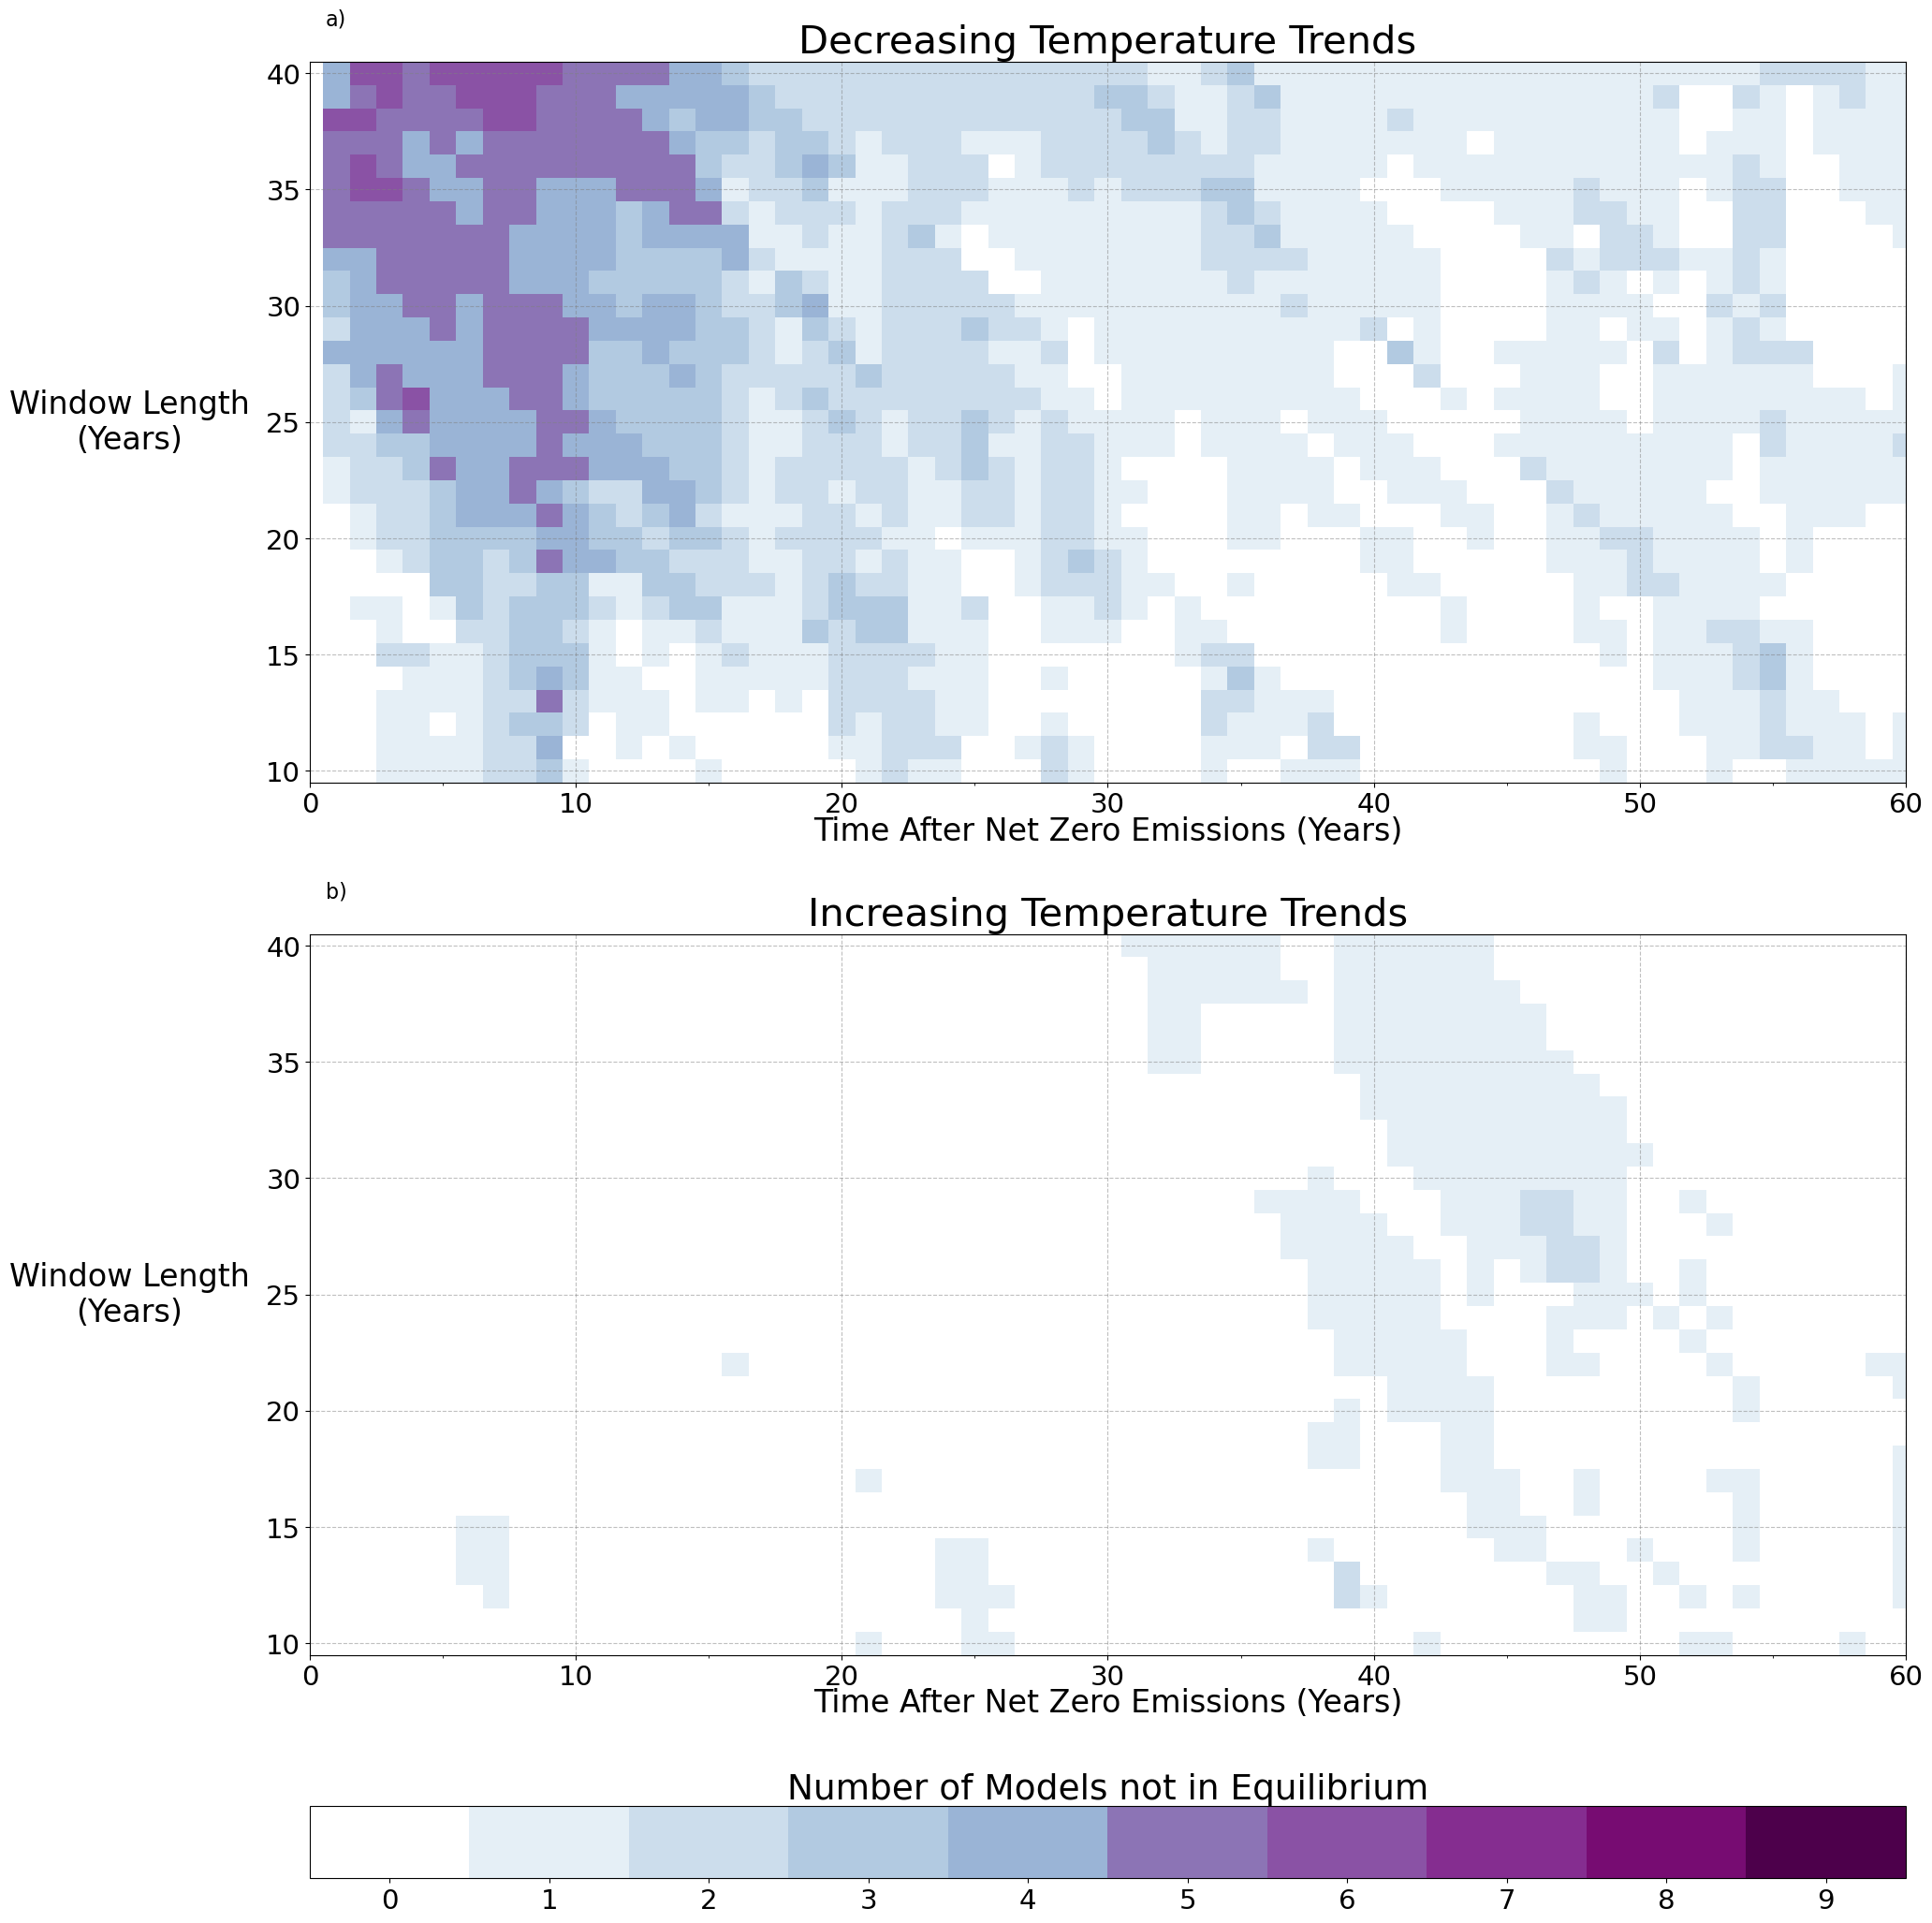

In [91]:
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*2.1))

gs = gridspec.GridSpec(3,1, height_ratios=[1, 1, 0.1], hspace=sn_plotting.plot_kwargs['hspace'])
axes = [fig.add_subplot(gs[i]) for i in range(3)]

sn_plotting.sn_multi_window_in_time(
    decreasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='Decreasing Temperature Trends', bbox_to_anchor=(1, 1.4),
    **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    increasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='Increasing Temperature Trends',
    add_legend=False, **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

for num, ax_ in enumerate(axes[:2]): plotting_functions.add_figure_label(ax_, f'{chr(97+num)})')

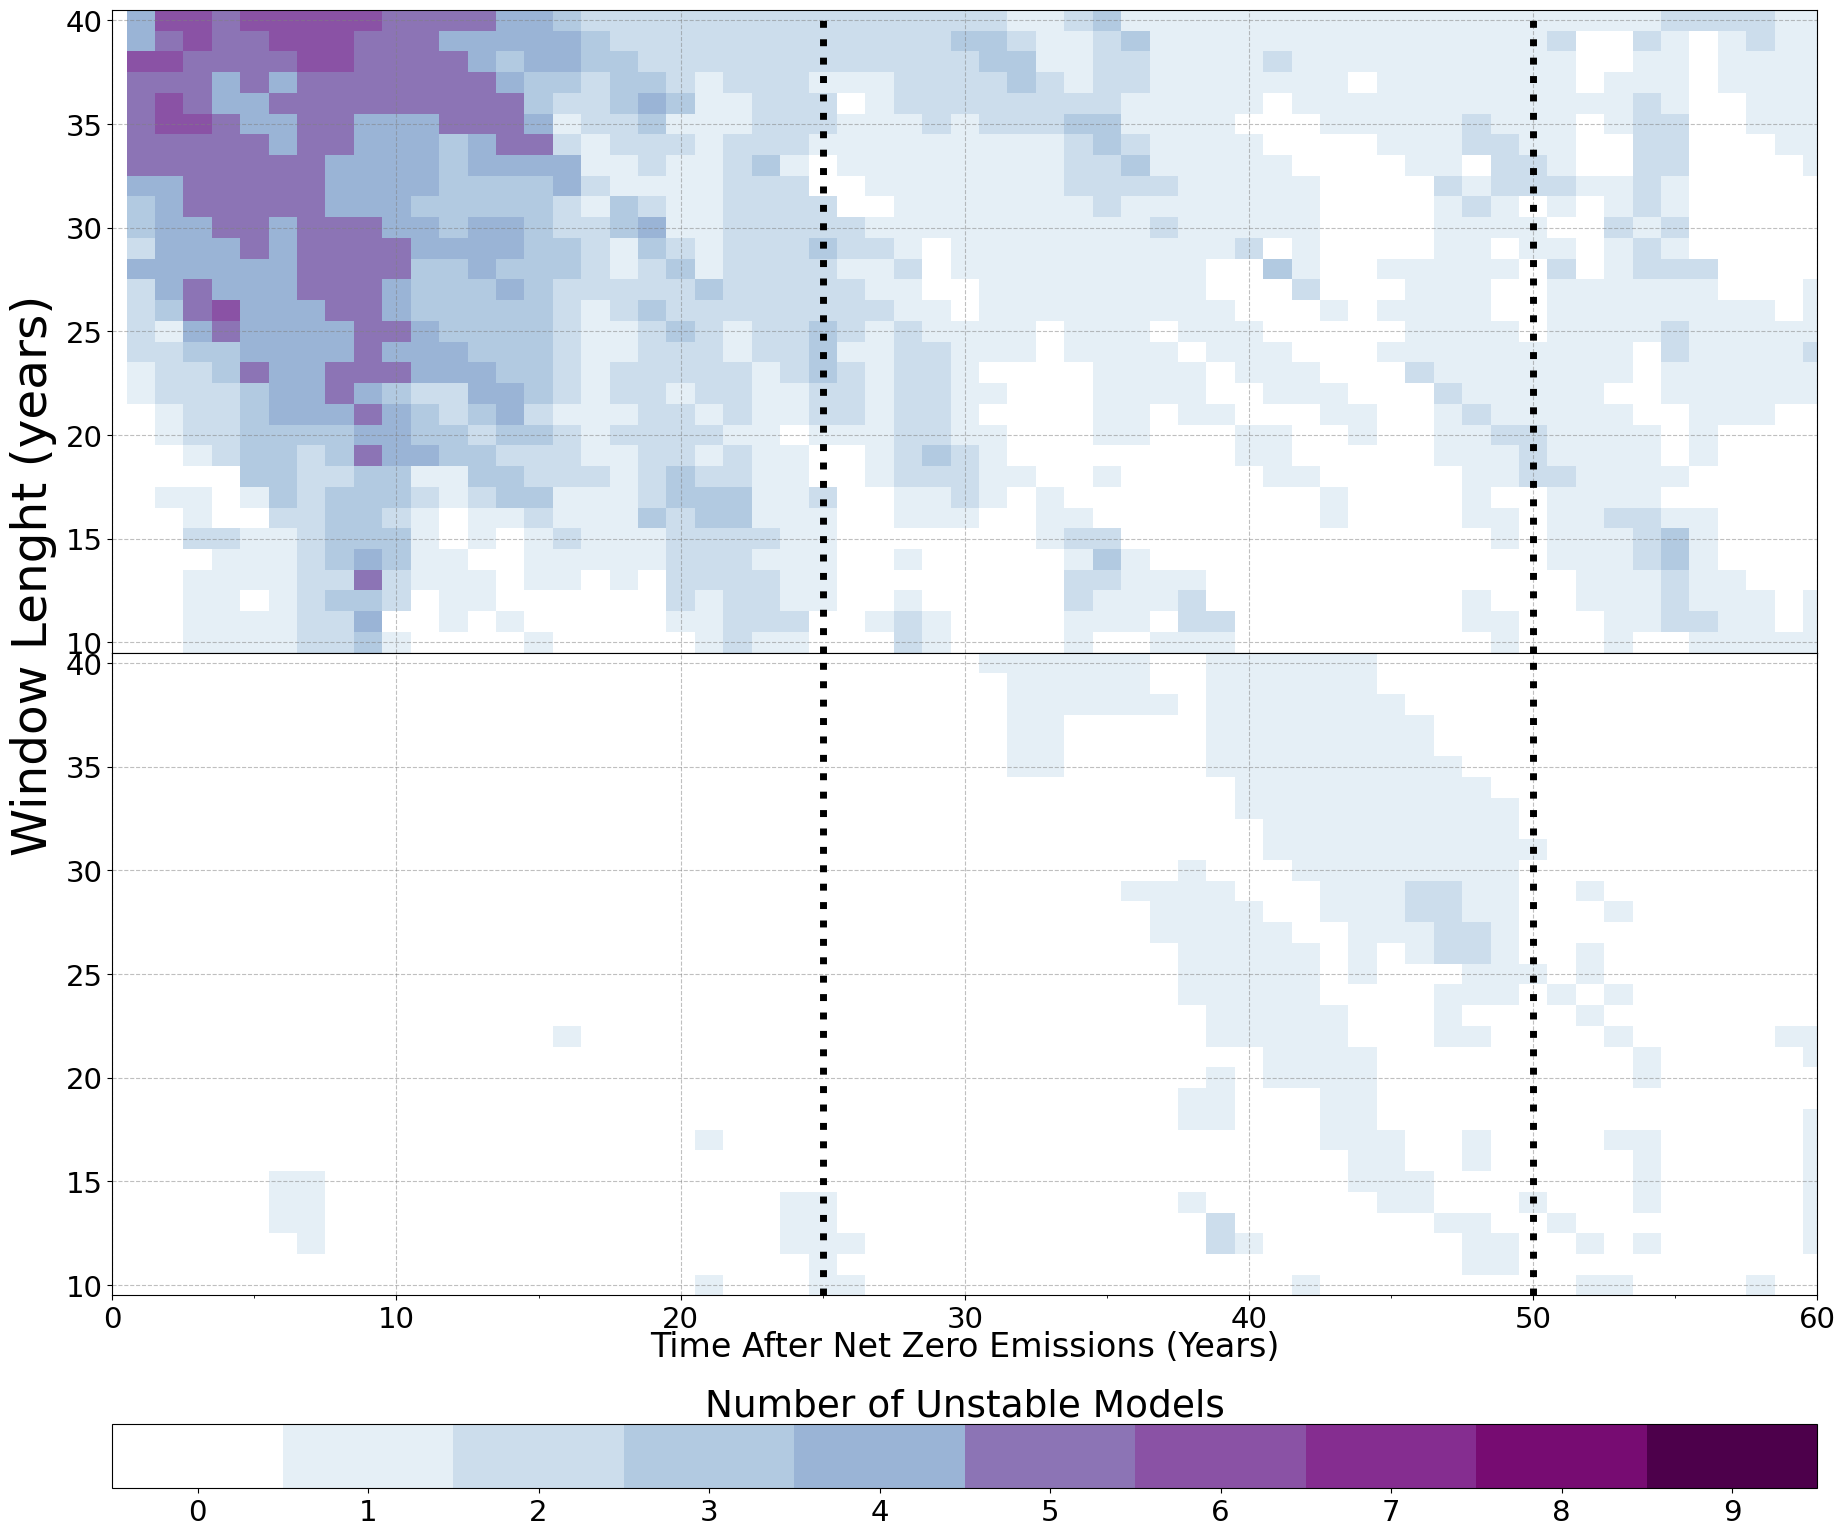

In [70]:
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*1.6))

gs = gridspec.GridSpec(4,1, height_ratios=[1, 1, 0.2, 0.1], hspace=0)
axes = [fig.add_subplot(gs[i]) for i in [0, 1, 3]]

sn_plotting.sn_multi_window_in_time(
    decreasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='',#'Decreasing Temperature Trends',
    ylabel='',
    bbox_to_anchor=(1, 1.4),
    **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    increasing_ds.sum(dim='model').signal_to_noise,
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='', ylabel='', #'Increasing Temperature Trends',
    add_legend=False, **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

for ax in axes[:2]:
    ax.axvline(increasing_ds.time.dt.year.values[24], 0, 1000, color='k', linewidth=5, linestyle=':')
    ax.axvline(increasing_ds.time.dt.year.values[49], 0, 1000, color='k', linewidth=5, linestyle=':')
axes[0].set_ylabel(''); axes[1].set_ylabel('')
axes[1].annotate('Window Lenght (years)', xy=(-.06, 0.7), size=35, xycoords='axes fraction', clip_on=False, rotation=90)
# for num, ax_ in enumerate(axes[:2]): plotting_functions.add_figure_label(ax_, f'{chr(97+num)})')
axes[0].set_xticklabels([]);

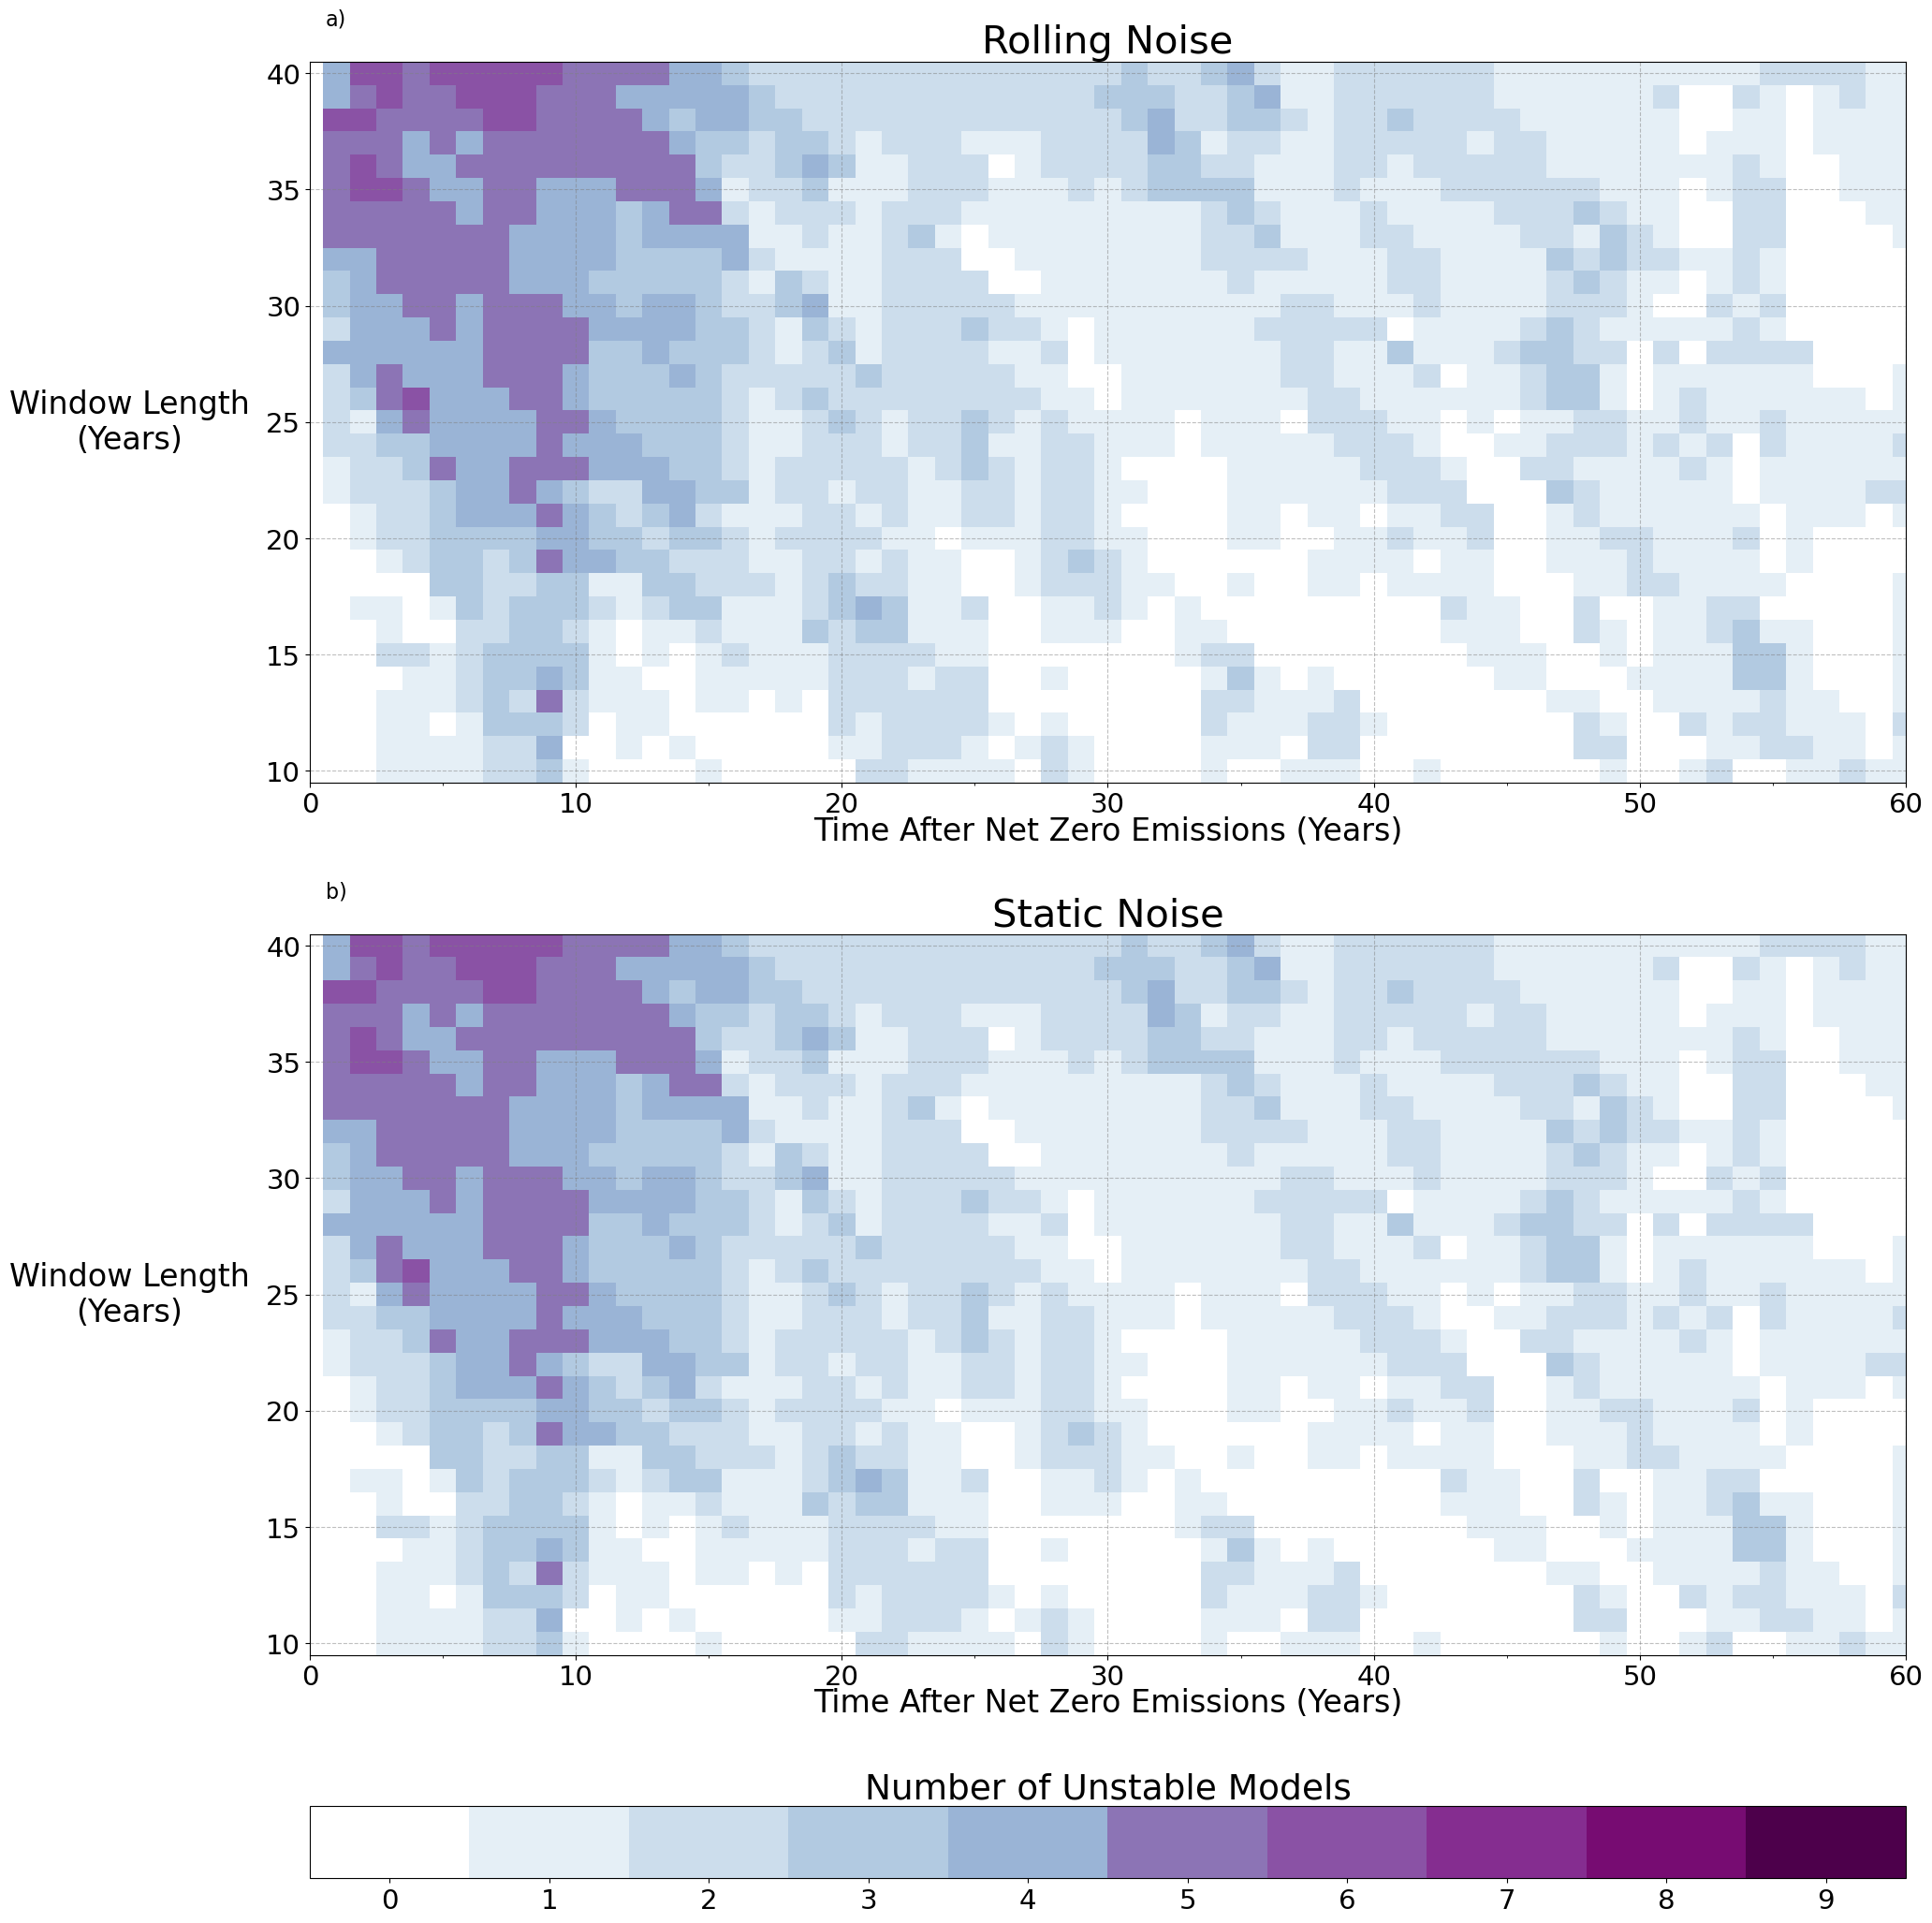

In [71]:
#### Rolling VS Static Noise

%matplotlib inline
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*2.1))

gs = gridspec.GridSpec(3,1, height_ratios=[1, 1, 0.1], hspace=sn_plotting.plot_kwargs['hspace'])
axes = [fig.add_subplot(gs[i]) for i in range(3)]

sn_plotting.sn_multi_window_in_time(
    rolling_stability_levels_ds.sel(stability='increasing').count(dim='model')+\
    rolling_stability_levels_ds.sel(stability='decreasing').count(dim='model'),
    cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='Rolling Noise', bbox_to_anchor=(1, 1.4),
    **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    static_stability_levels_ds.sel(stability='increasing').count(dim='model')+\
    static_stability_levels_ds.sel(stability='decreasing').count(dim='model')
    , cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='Static Noise',
    add_legend=False, **stability_colorplot_kwargs_no_temp_line,  **plot_kwargs)

for num, ax_ in enumerate(axes[:2]): plotting_functions.add_figure_label(ax_, f'{chr(97+num)})')

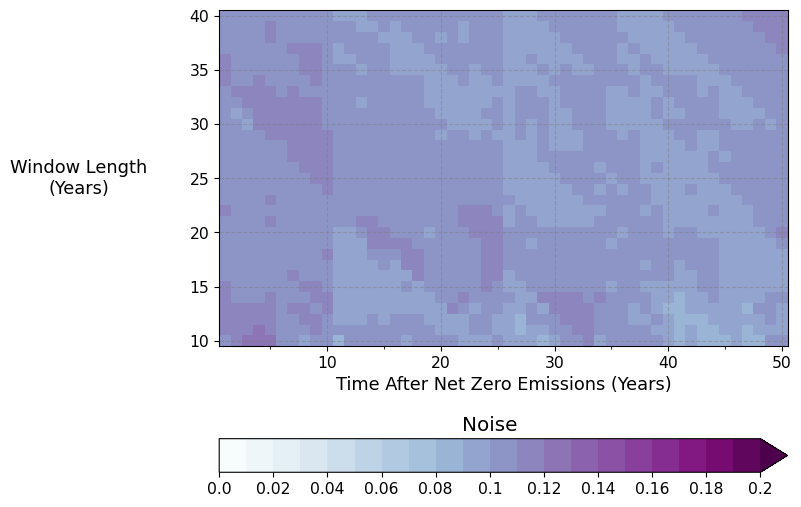

In [72]:
# Noise Median
noise_levels = sn_plotting.create_levels(vmax=.2, vmin=0, step=.01)
sn_plotting.plot_heatmap(sn_multi_rolling_ds.noise.median(dim='model'), levels=noise_levels, 
                                figsize=(sn_plotting.plot_kwargs['width']/3,
                                         sn_plotting.plot_kwargs['height']/2), 
                               cmap='BuPu', extend='max', cut_ticks=2, max_color_lim=50, 
                               font_scale=0.8, cbar_label='Noise', hspace=0.2, return_all=False)

In [73]:
models = a1_smean_anom_ds.model.values

- full garbage collection released 63.79 MiB from 105522 reference cycles (threshold: 9.54 MiB)
- Event loop was unresponsive in Scheduler for 3.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 3.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 3.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 4.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
- Event loop was unresponsive in Nanny for 4.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts an

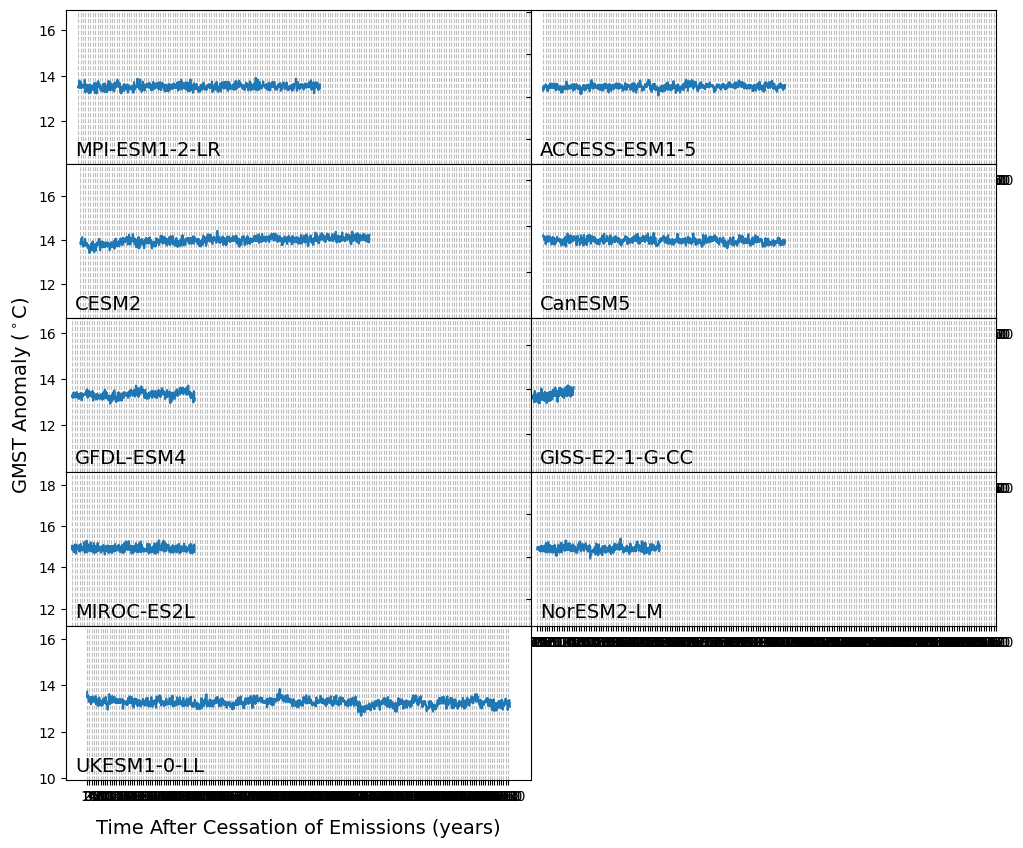

In [74]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(models):
    ds = esmpi_smean_ds.sel(model=model).squeeze()
    mean = ds.mean().values
    ax = axes[num]
    ax.plot(ds.time.values, ds.values, label=model)
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim(*(mean* 0.75, mean*1.25))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    if num%2: ax.set_yticklabels([])
    ax.axhline([0], zorder=-10, color='grey', alpha=0.5, linestyle='--')
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.dt.year.values-1)
    ax.xaxis.grid(True, alpha=0.5, c='grey', linestyle='--')

axes[-1].set_xlabel('Time After Cessation of Emissions (years)', va='bottom', fontsize=14, labelpad=25);

In [75]:
esmpi_smean_xrlist

key_dim = model


Number of da/ds: 9
---------------
MPI-ESM1-2-LR ({'model': 1, 'time': 1000})
ACCESS-ESM1-5 ({'model': 1, 'time': 1000})
CESM2         ({'model': 1, 'time': 1200})
CanESM5       ({'model': 1, 'time': 1000})
GFDL-ESM4     ({'model': 1, 'time': 500})
GISS-E2-1-G-CC({'model': 1, 'time': 165})
MIROC-ES2L    ({'model': 1, 'time': 500})
NorESM2-LM    ({'model': 1, 'time': 501})
UKESM1-0-LL   ({'model': 1, 'time': 1880})

In [76]:
yticks = ax.get_yticks()[1:-1]
yticks

array([10., 12., 14., 16.])

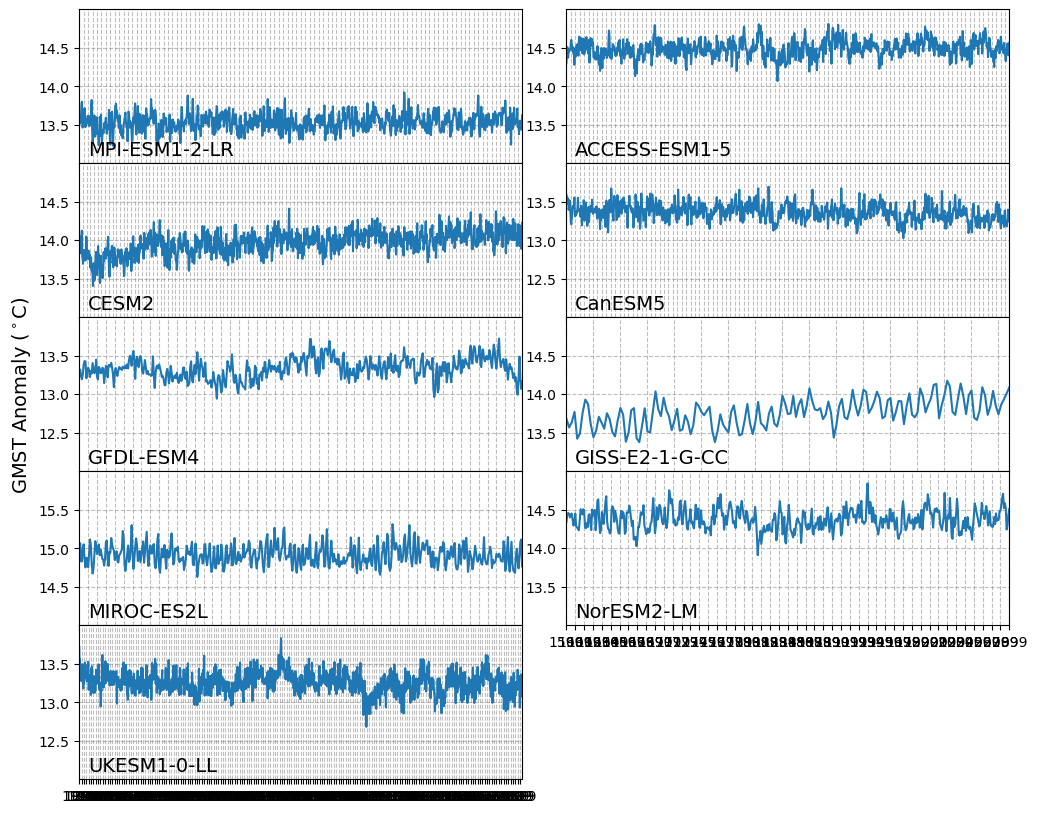

In [77]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds) in enumerate(esmpi_smean_xrlist):
    ax = axes[num]
    # ds = utils.reset_time_to_0_start(ds)
    # ds['time'] = ds.time.dt.year.values
    
    ax.plot(ds.time.values, ds.squeeze().values) #label='1% CO2')
    
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    mid_points = np.round(ds.median().values.item(), 0)
    ax.set_ylim([mid_points-1, mid_points+1])
    ax.set_yticks(ax.get_yticks()[1:-1])
    #ax.set_yticks(np.arange(mid_points-0.5, mid_points+.75, 0.25))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    # if num%2: ax.set_yticklabels([])
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.dt.year.values-1)
#     #ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='Abrupt Zero CO2 Emissions Point')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    if num not in [7, 8]: ax.set_xticklabels('')

# leg = axes[0].legend(ncol=4, bbox_to_anchor=[2.1, 1.4], fontsize=12)
# axes[-1].set_xlabel('Time After Simulation Start (years)', va='bottom', fontsize=14, labelpad=25);

In [78]:
print(pct_smean_xrlist[0])

<xarray.DataArray 'tas' (model: 1, time: 165)>
array([[13.47895885, 13.52256784, 13.71727354, 13.8294275 , 13.68471955,
        13.61604472, 13.54002163, 13.56995384, 13.65571247, 13.77125787,
        13.87240654, 13.8574866 , 13.94702191, 14.0442844 , 13.98384183,
        14.03072662, 13.90328632, 13.90900808, 14.03472885, 14.15430114,
        14.02488396, 13.89258248, 13.86375937, 13.92427527, 14.08148535,
        14.10307212, 14.19529265, 14.10680876, 14.1445625 , 13.95702582,
        14.17496367, 14.31218357, 14.40636106, 14.36938084, 14.26965817,
        14.26258888, 14.37003506, 14.59349265, 14.504815  , 14.46612606,
        14.50984808, 14.33476505, 14.46104187, 14.5470949 , 14.48456063,
        14.41149769, 14.54238569, 14.53376862, 14.54686362, 14.57979552,
        14.94906091, 15.11020656, 14.82844618, 14.85130597, 14.79453714,
        14.87389201, 14.95165072, 15.04966439, 14.92692648, 14.96676497,
        15.07886056, 15.14344007, 15.00581542, 15.03470694, 15.10943979,
    

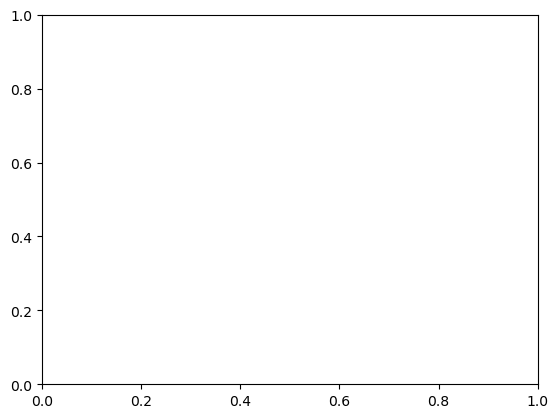

In [79]:
fig, ax = plt.subplots()

Text(0.5, 0, 'Time After Simulation Start (years)')

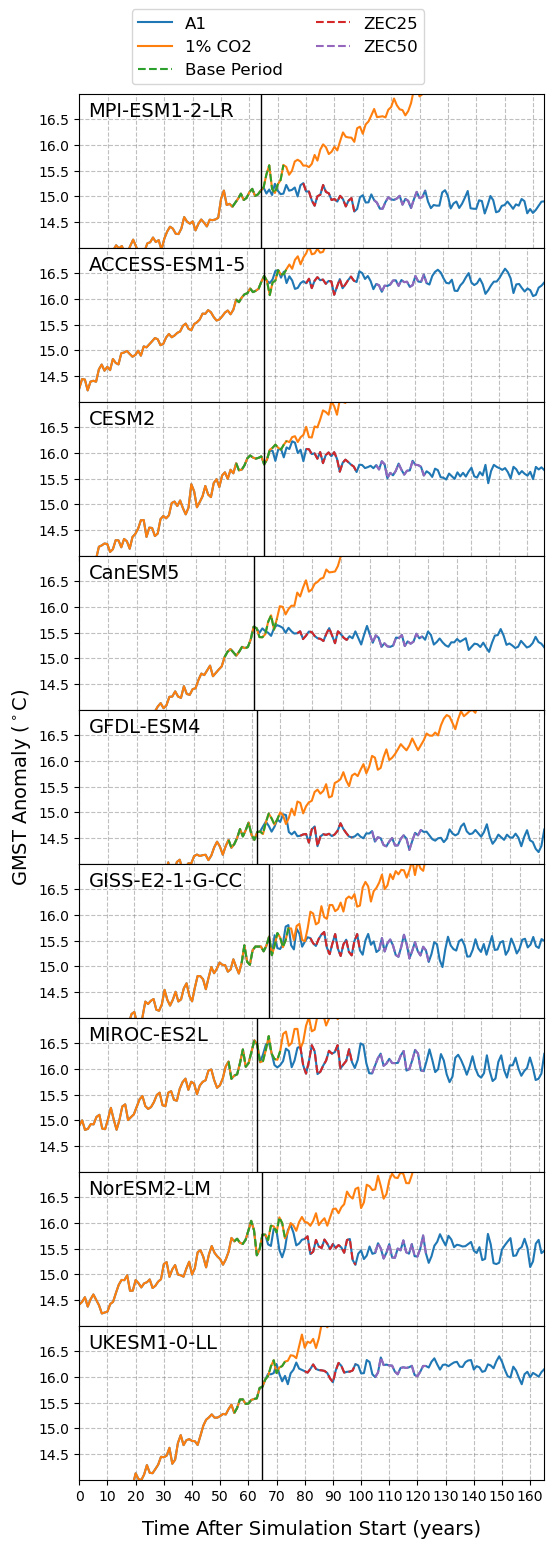

In [80]:
ncols = 1
models = pct_smean_xrlist.refkeys
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds_orig) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds = ds_orig.copy(deep=True)  # Create a deep copy to avoid modifying the original dataset
    ds2 = a1_smean_xrlist[model].copy(deep=True)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    
    # Ensure that reset_time_to_0_start returns a new dataset
    ds = utils.reset_time_to_0_start(ds.copy(deep=True))
    ds_orig = utils.reset_time_to_0_start(ds_orig.copy(deep=True))  # Create a deep copy to avoid modifying the original dataset
    
    ds['time'] = ds.time.dt.year.values
    ds_orig['time'] = ds_orig.time.dt.year.values
    
    
    ax.plot(ds.time.values, ds.squeeze().values, label='A1')
    ax.plot(ds_orig.time.values, ds_orig.squeeze().values, label='1% CO2')
    
    ds_base = ds_orig.isel(time=slice(start_arg-10, start_arg+9))
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period', linestyle='--')

    ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC25', linestyle='--')
    
    ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC50', linestyle='--')
    
    
    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([14, 17])
    ax.set_yticks(np.arange(14.5, 17, 0.5))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    #if num%2: ax.set_yticklabels([])
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black')#, label='A1')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    if num not in [8]: ax.set_xticklabels('')

leg = axes[0].legend(ncol=2, bbox_to_anchor=[0.76, 1.6], fontsize=12)
axes[-1].set_xlabel('Time After Simulation Start (years)', va='bottom', fontsize=14, labelpad=25)

In [81]:
ds_base.mean(dim='time').values.item()

15.806567622409721

Text(0.5, 0, 'Time After Simulation Start (years)')

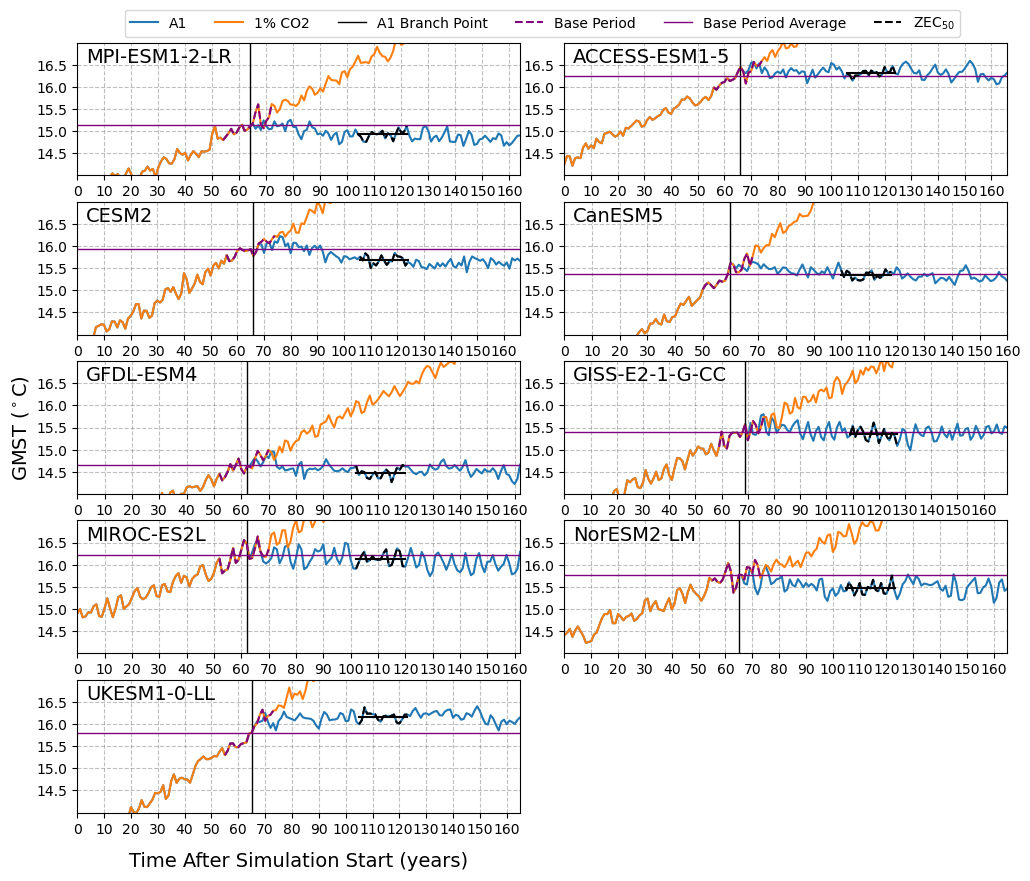

In [82]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds_orig) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds = ds_orig.copy(deep=True)  # Create a deep copy to avoid modifying the original dataset
    ds2 = a1_smean_xrlist[model].copy(deep=True)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    
    # Ensure that reset_time_to_0_start returns a new dataset
    ds = utils.reset_time_to_0_start(ds.copy(deep=True))
    ds_orig = utils.reset_time_to_0_start(ds_orig.copy(deep=True))  # Create a deep copy to avoid modifying the original dataset
    
    ds['time'] = ds.time.dt.year.values
    ds_orig['time'] = ds_orig.time.dt.year.values
    
    ds_base = ds_orig.isel(time=slice(start_arg-10, start_arg+9))

    # A1
    ax.plot(ds.time.values, ds.squeeze().values, label='A1')
    # 1% CO2
    ax.plot(ds_orig.time.values, ds_orig.squeeze().values, label='1% CO2')

    # Vertical Line marking start of A1
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='A1 Branch Point')

    # Base period dashed line
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period', linestyle='--', color='purple')
    
    # Line for the average of the base period
    ax.axhline(ds_base.mean(dim='time').values.item(), linewidth=1, color='purple', label='Base Period Average')
    
    #Dashed lines for ZEC25 and ZEC50
    # ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    # ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC'+r'$_{25}$', linestyle='--')
    ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    ax.plot(ds_50.time.values, np.tile(ds_50.mean().values, len(ds_50.time.values)), color='black')
    ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC'+r'$_{50}$', linestyle='--', color='black')

    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([14, 17])
    ax.set_yticks(np.arange(14.5, 17, 0.5))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)

    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    #if num not in [7, 8]: ax.set_xticklabels('')

# Place the legend at the center just above the first row of plots
# Adjust the bbox_to_anchor values to center the legend
leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
axes[-1].set_xlabel('Time After Simulation Start (years)', va='bottom', fontsize=14, labelpad=25)

Text(0.5, 0, 'Time After Simulation Start (years)')

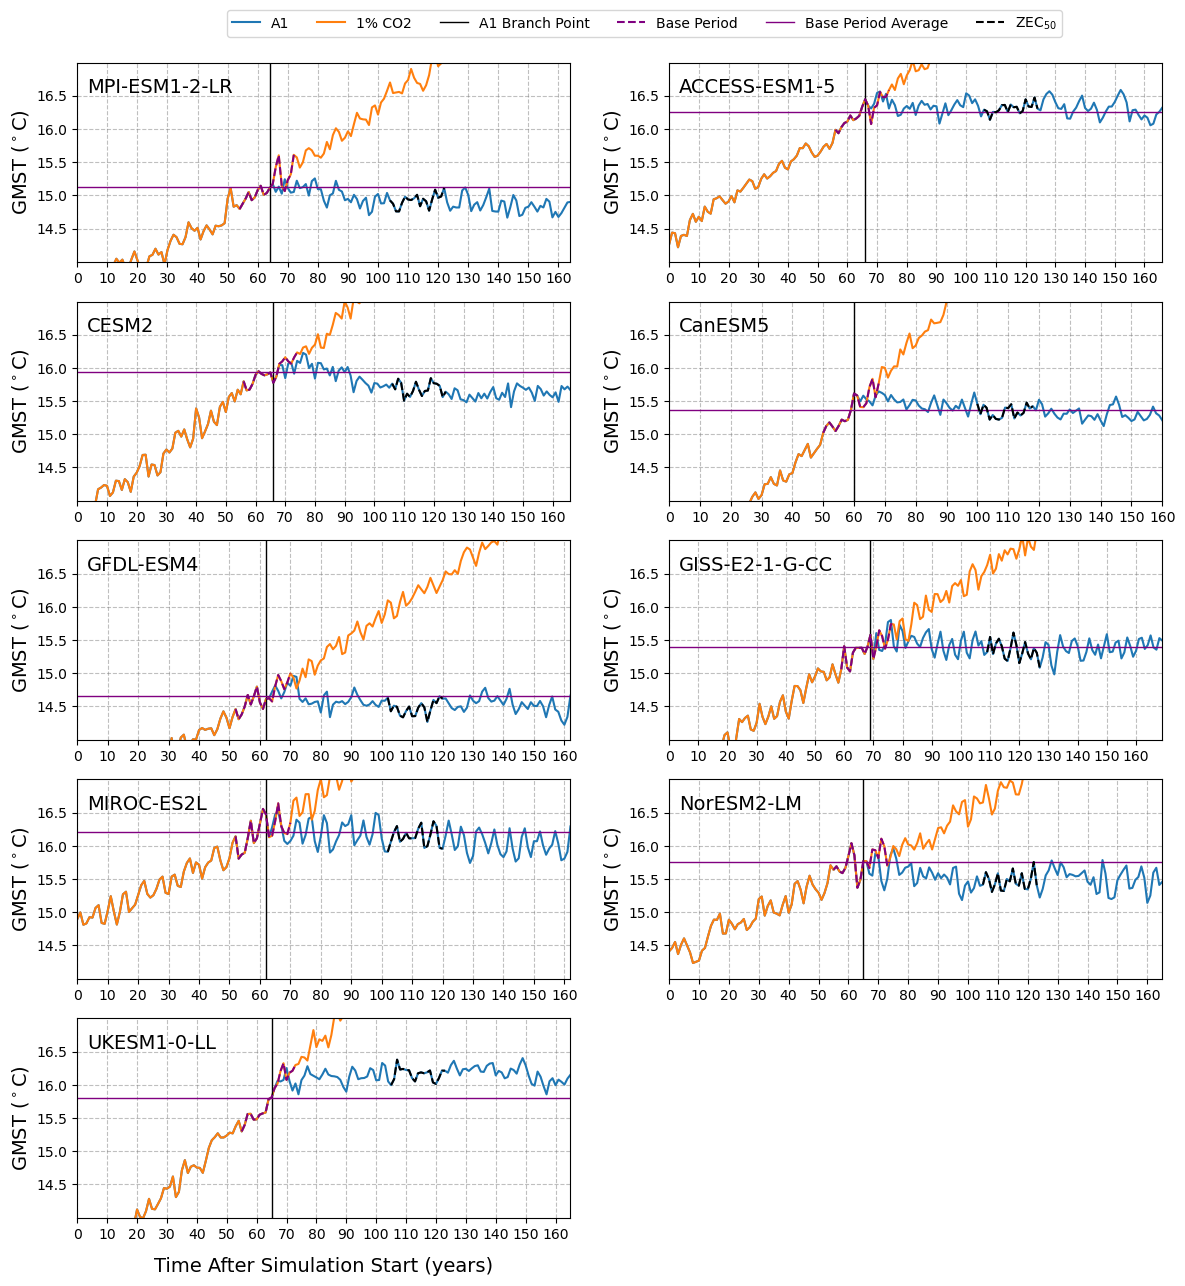

In [83]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(7*ncols, 3*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=.2)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds_orig) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds = ds_orig.copy(deep=True)  # Create a deep copy to avoid modifying the original dataset
    ds2 = a1_smean_xrlist[model].copy(deep=True)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    
    # Ensure that reset_time_to_0_start returns a new dataset
    ds = utils.reset_time_to_0_start(ds.copy(deep=True))
    ds_orig = utils.reset_time_to_0_start(ds_orig.copy(deep=True))  # Create a deep copy to avoid modifying the original dataset
    
    ds['time'] = ds.time.dt.year.values
    ds_orig['time'] = ds_orig.time.dt.year.values
    
    ds_base = ds_orig.isel(time=slice(start_arg-10, start_arg+9))

    # A1
    ax.plot(ds.time.values, ds.squeeze().values, label='A1')
    # 1% CO2
    ax.plot(ds_orig.time.values, ds_orig.squeeze().values, label='1% CO2')

    # Vertical Line marking start of A1
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='A1 Branch Point')

    # Base period dashed line
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period', linestyle='--', color='purple')
    
    # Line for the average of the base period
    ax.axhline(ds_base.mean(dim='time').values.item(), linewidth=1, color='purple', label='Base Period Average')
    
    #Dashed lines for ZEC25 and ZEC50
    # ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    # ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC'+r'$_{25}$', linestyle='--')
    ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC'+r'$_{50}$', linestyle='--', color='black')

    ax.annotate(model, xy=(0.02, 0.85), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([14, 17])
    ax.set_yticks(np.arange(14.5, 17, 0.5))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    ax.set_ylabel('GMST ' + r'($^\circ$C)', fontsize=14)
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)

    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    #if num not in [7, 8]: ax.set_xticklabels('')

# Place the legend at the center just above the first row of plots
# Adjust the bbox_to_anchor values to center the legend
leg = axes[1].legend(ncol=7, bbox_to_anchor=[-0.05, 1.3], loc='upper center', fontsize=10)
axes[-1].set_xlabel('Time After Simulation Start (years)', va='bottom', fontsize=14, labelpad=25)

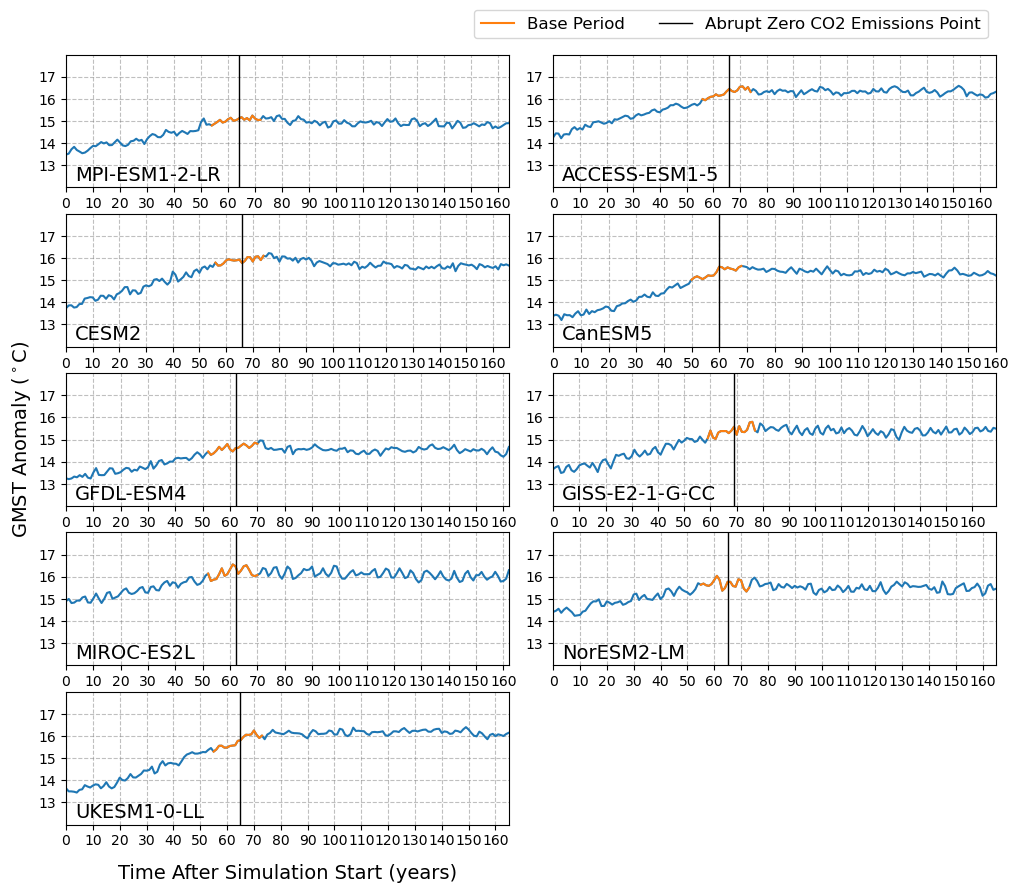

In [84]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.2, wspace=0.1)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds) in enumerate(pct_smean_xrlist):
    ax = axes[num]
    ds2 = a1_smean_xrlist[model]
    # ax.plot(ds.time.values, ds.squeeze().values)
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.combine_first(ds2)
    start_arg = np.argwhere(ds.time.values == ds2.time.values[0]).item()
    ds = utils.reset_time_to_0_start(ds)
    ds['time'] = ds.time.dt.year.values
    
    ax.plot(ds.time.values, ds.squeeze().values) #label='1% CO2')
    ds_base = ds.isel(time=slice(start_arg-10, start_arg+9))
    ax.plot(ds_base.time.values, ds_base.squeeze().values, label='Base Period')

    # ds_25 = ds.isel(time=slice(start_arg+25-10, start_arg+25+9))
    # ax.plot(ds_25.time.values, ds_25.squeeze().values, label='ZEC25 Period')
    
    
    # ds_50 = ds.isel(time=slice(start_arg+50-10, start_arg+50+9))
    # ax.plot(ds_50.time.values, ds_50.squeeze().values, label='ZEC50 Period')
    
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([12, 18])
    ax.set_yticks(np.arange(13, 18, 1))
    ax.set_xlim(np.take(ds.time.values, [0, -1]))
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    #if num%2: ax.set_yticklabels([])
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.values-1)
    ax.axvline(ds.time.values[start_arg], linewidth=1, color='black', label='Abrupt Zero CO2 Emissions Point')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    #if num not in [7, 8]: ax.set_xticklabels('')

leg = axes[0].legend(ncol=4, bbox_to_anchor=[2.1, 1.4], fontsize=12)
axes[-1].set_xlabel('Time After Simulation Start (years)', va='bottom', fontsize=14, labelpad=25);

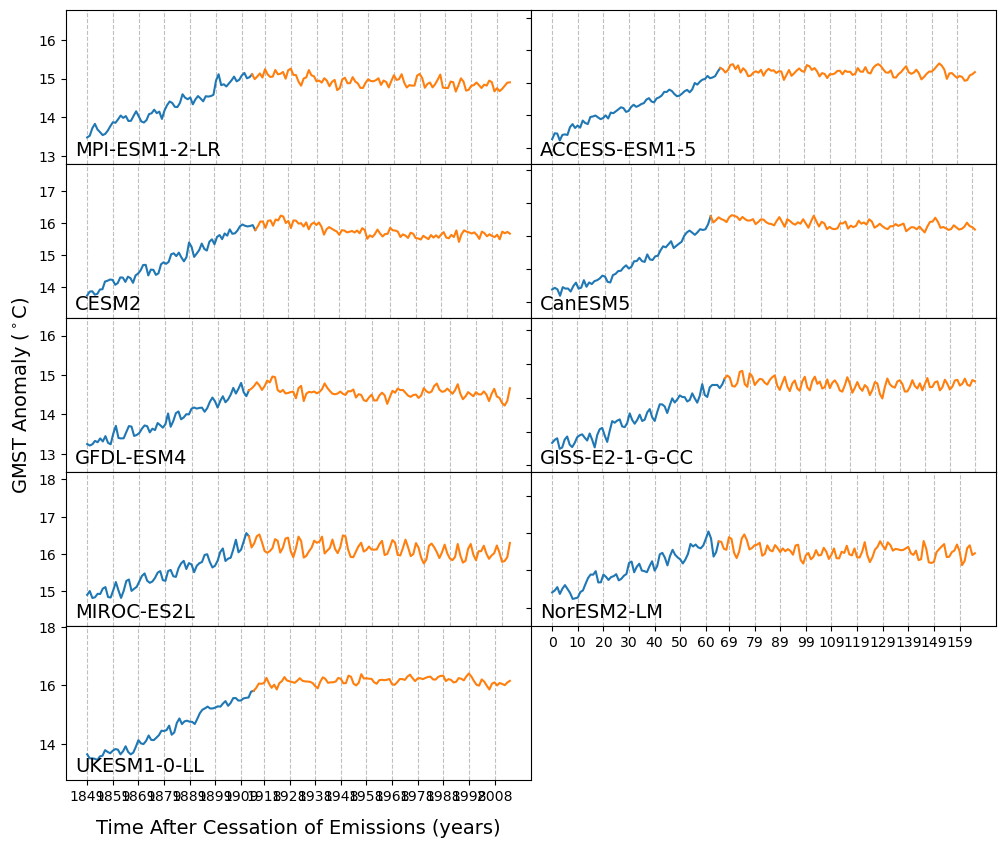

In [85]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, (model, ds) in enumerate(pct_smean_xrlist):
    ds2 = a1_smean_xrlist[model]
    ax = axes[num]
    ds  = ds.sel(time=slice(None, ds2.time.values[0]))
    ds2 = ds2.combine_first(ds.isel(time=slice(-2, -1)))
    ds = ds.isel(time=slice(None, -1))
    ax.plot(ds.time.values, ds.squeeze().values, label='1% CO2')
    ax.plot(ds2.time.values, ds2.squeeze().values, label='A1')
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    llim = 0.95 * np.min([ds.min().values, ds2.min().values])
    ulim = 1.1 * np.max([ds.max().values, ds2.max().values])
    # llim=12; ulim=18
    ax.set_ylim([llim, ulim])
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    if num%2: ax.set_yticklabels([])
    ax.axhline([0], zorder=-10, color='grey', alpha=0.5, linestyle='--')
    sn_plotting.format_xticks(ax, np.concatenate([ds.time.values, ds2.time.values]), 
                              np.concatenate([ds.time.dt.year.values, ds2.time.dt.year.values])-1)
    ax.xaxis.grid(True, alpha=0.5, c='grey', linestyle='--')
    ax.axvline(ds2.time.values[0], llim, ulim, color='red')


axes[-1].set_xlabel('Time After Cessation of Emissions (years)', va='bottom', fontsize=14, labelpad=25);

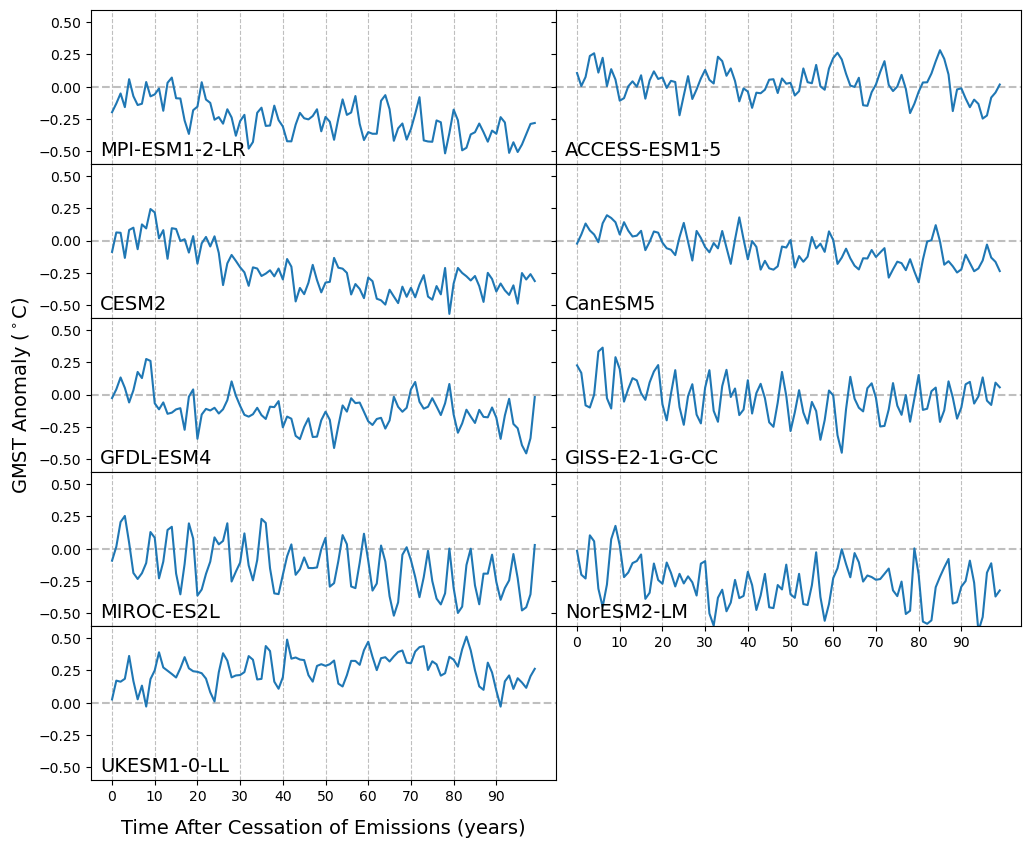

In [86]:
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(6*ncols, 2*nrows))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(models):
    ds = a1_smean_anom_ds.sel(model=model).squeeze()
    ax = axes[num]
    ax.plot(ds.time.values, ds.values, label=model)
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([-0.6, 0.6])
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    if num%2: ax.set_yticklabels([])
    ax.axhline([0], zorder=-10, color='grey', alpha=0.5, linestyle='--')
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.dt.year.values-1)
    ax.xaxis.grid(True, alpha=0.5, c='grey', linestyle='--')

axes[-1].set_xlabel('Time After Cessation of Emissions (years)', va='bottom', fontsize=14, labelpad=25);

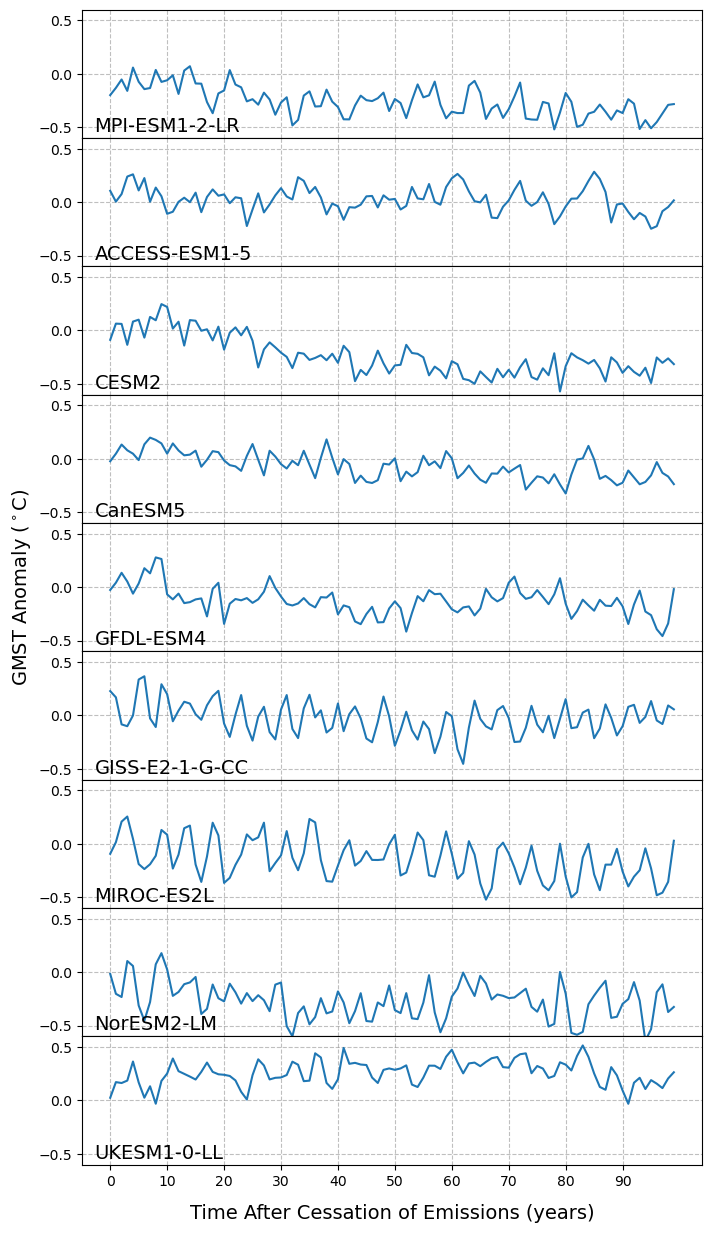

In [87]:
fig = plt.figure(figsize=(8, 15))
gs = gridspec.GridSpec(9, 1, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for num, model in enumerate(a1_smean_anom_ds.model.values):
    ds = a1_smean_anom_ds.sel(model=model).squeeze()
    ax = axes[num]
    ax.plot(ds.time.values, ds.values, label=model)
    ax.annotate(model, xy=(0.02, 0.05), fontsize=14, xycoords='axes fraction')
    ax.set_ylim([-0.6, 0.6])
    if num == np.ceil(len(models)/2)-1: ax.set_ylabel('GMST Anomaly ' + r'($^\circ$C)', fontsize=14)
    sn_plotting.format_xticks(ax, ds.time.values, ds.time.dt.year.values-1)
    #ax.axhline([0], zorder=-10, color='grey', alpha=0.3, linestyle='--')
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')

ax.set_xlabel('Time After Cessation of Emissions (years)', va='bottom', fontsize=14, labelpad=25);

NameError: name 'pymannkendall' is not defined

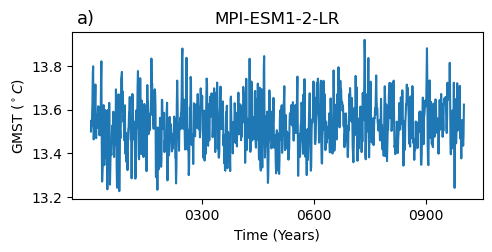

In [88]:
models = esmpi_smean_xrlist.refkeys
ncols = 3; nrows = int(np.ceil(len(models)/2))

fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, hspace=0.6)

for num, (model, ds) in enumerate(esmpi_smean_xrlist):
    ax = fig.add_subplot(gs[num])
    time = utils.convert_to_0_start_cftime(ds.time.values)
    ax.plot(time,ds.squeeze())
    
    plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=0.8)
    ax.set_title(model); ax.set_ylabel(r'GMST $(^\circ C)$'); ax.set_xlabel('Time (Years)')
    # ax.set_xlim([time[0], time[-1]])
    
    init_y = ds.squeeze().values
    x = np.arange(len(init_y))
    grad_yint = np.polyfit(x, init_y, deg=1)

    fitted_line = np.polyval(grad_yint, x)
    mk_val = pymannkendall.original_test(init_y)
    mk_pval = mk_val.p
    if mk_pval < 0.05:
        color = 'red'
        label = f'Gradient = {grad_yint[0]*500:.2f}' + r'$^\circ$C (500yr)$^{-1}$' + f'\np-value = {mk_pval:.3f}'
    else:
        color='grey'
        label=None
    
    ax.plot(time, fitted_line, linestyle='--', alpha=0.6, color=color, label=label)
    ax.grid(True, alpha=0.5, c='grey', linestyle='--')
    if mk_pval < 0.05: ax.legend(ncol=1, loc='best')#bbox_to_anchor=(0.6, 1.06))